<a href="https://colab.research.google.com/github/dipankarsrirag/Dialogue-Summarisation/blob/main/notebooks/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Comparative Analysis of Abstractive Dialogue Summarization: Seq2Seq Encoder-Decoder vs. Advanced Architectures like BART and T5

**Group Name: Able Elba**

|       Name      | Email Address | Student ID|
|-----------------|---------------|-----------|
| Dipankar Srirag | z5437514@ad.unsw.edu.au | z5437514 |
| Pratyush Ravindrakumar Panda | z5410294@ad.unsw.edu.au | z5410294 |
|Pinak Sharma|z5311106@ad.unsw.edu.au|z5311106|
|Kazi Mahibul Hasan|z5359206@ad.unsw.edu.au|z5359206|
|Serkan Akin|z5519653@ad.unsw.edu.au|z5519653|




## Table of Contents

1. Introduction
2. Data Sources
3. Performance Metrics
4. Exploring Data
5. Methodology
    - Custom Seq2Seq Model
    - FLAN-T5
    - BART
6. Conclusion
7. Future Works

## Introduction

The purpose of this study is to undertake a thorough comparative investigation of many approaches to abstractive summarization, particularly in the context of dialogue processing within the Natural Language Processing (NLP) discipline. It compares the effectiveness of a static embedding-based Seq2Seq Encoder-Decoder model to that of more complicated transformer architectures such as BART (Bidirectional and Auto-Regressive Transformers) and T5 (Text-to-Text Transfer Transformer).

### Problem Statement

Abstractive dialogue summarisation is an important domain in NLP, responsible for compressing long-winded conversations into short, contextually full summaries. The inherent complexity and multidimensionality of conversations pose a significant challenge in accurately documenting the critical nuances and vital features. This study intends to analyse and compare the performance differences between simpler Seq2Seq Encoder-Decoder models that rely on static embeddings and more advanced, contextually dynamic models such as BART and T5.

### Motivation

The motivation for this comparison analysis originates from a strong desire to investigate the capabilities and limitations of various embedding approaches within transformer models. The research focuses on distinguishing between static embeddings, such as GloVe, and context-aware embeddings, such as those utilised in BART and T5 models. Among the primary motivations are:

1. **Exploration of Static vs. Context-Aware Embeddings:** There is a strong interest in examining the performance of static embeddings, which, despite being pre-trained on large corpora, lack contextual sensitivity as compared to dynamic, context-adaptive embeddings of more advanced models. The purpose of this comparison is to determine the effect of two fundamentally different embedding methodologies on the efficacy of dialogue summarization.

2. Knowledge of Embedding Technologies: This study has the potential to improve our understanding of embedding technologies in NLP. By comparing static versus context-aware embeddings, the study seeks to provide insights into future research and model selection tactics in diverse NLP applications.

3. **Analysis of Comparative Model Selection** The overarching goal is to provide a framework for comparison to assist academics and practitioners in determining the appropriate model architecture. This is especially true given the disparities in resource requirements, complexity, and performance capabilities between Seq2Seq models with static embeddings and advanced models like BART and T5.


This research is essentially an exploratory excursion into the world of embedding technologies in the context of abstractive dialogue summarization. It seeks to provide a more nuanced understanding of static versus dynamic embedding methodologies, therefore improving the area of NLP and assisting in informed model selection for a variety of language problems


## Data Sources

We are using the DialogSum dataset for this project, which is a comprehensive and large-scale discussion summary resource. This dataset contains 13,460 dialogues, each linked with manually labelled summaries and topics, and serves as a solid foundation for our research. The following information provides a clear guidance to accessing and comprehending this dataset:

1. **Main Source:** The DialogSum dataset is available from its original repository at [DialogSum GitHub Repository](https://github.com/cylnlp/DialogSum). This data is utilised to build a bespoke pipeline for our seq2seq model.

2. **Secondary Pretrained Model Source:** The DialogSum dataset is also available through the Hugging Face Datasets library for fine-tuning pretrained models like BART and T5, notably at [DialogSum on Hugging Face](https://huggingface.co/datasets/knkarthick/dialogsum). This version is designed for use with  pretrained models.

3. **Dataset Characteristics:** DialogSum stands out from other dialogue datasets, such as SAMSUM, due to its meticulous preprocessing. This preprocessing includes the correction of grammatical errors in the dialogues and the provision of well-annotated summaries in formal language. Such refinement enhances the dataset's utility for our project. The dataset also provides a hidden test set to perform summarisation on completely new unnanotated dialogues.

4. **Empirical Study Reference:** An empirical study assessing the performance of Large Language Models (LLMs) on the DialogSum dataset is detailed in the corresponding [research paper](https://aclanthology.org/2021.findings-acl.449.pdf). This paper offers valuable insights and benchmarks that can inform and guide our analysis.

By utilising the DialogSum dataset from these stated sources, our study will be able to undertake a full and informed comparison of the Seq2Seq Transformer model with static embeddings vs sophisticated models such as BART and T5, which use context-aware embeddings.


## Performance Metrics

Selecting appropriate metrics for evaluation is critical, especially for a task as complex as summarization. Given the rapid advancements in summarization research, several metrics are available:

### ROUGE
**Recall-Oriented Understudy for Gisting Evaluation (ROUGE)** is a widely recognized method for evaluating text-to-text generation tasks like Machine Translation and Summarization. Among the various ROUGE metrics, we focus on:
- **ROUGE-1**: This measures the overlap of unigrams (single words) between the system-generated and reference summaries. It is calculated as follows:
  $$ \text{ROUGE-1} = \frac{\sum_{s \in \text{System Summaries}} \sum_{w \in s} \text{Count}_{\text{match}}(w)}{\sum_{s \in \text{Reference Summaries}} \sum_{w \in s} \text{Count}(w)} $$
- **ROUGE-2**: This metric evaluates the overlap of bigrams between the system and reference summaries.
- **ROUGE-L**: This is based on the Longest Common Subsequence (LCS). It considers sentence-level structural similarity by identifying the longest co-occurring sequence of n-grams. The formula for ROUGE-L is:
  $$ \text{ROUGE-L} = \frac{\sum_{l \in \text{LCS}} \text{Length}(l)}{\text{Length}(\text{Reference Summary})} $$

### BLEU Score
Though primarily used in Machine Translation, the **BLEU Score** complements ROUGE by addressing its limitations. BLEU evaluates the quality of machine-generated text by calculating the precision of n-grams.

### Human Evaluation
Despite the efficacy of ROUGE and BLEU in quantitative evaluation, they rely on token or sentence overlap, which might not fully capture the nuances of abstractive summarization. Therefore, we also conducted human evaluations to assess the accuracy and coherence of the generated summaries.


**Setting Environment**

In [1]:
!pip install -U transformers &> /dev/null
!pip install -U accelerate &> /dev/null
!pip install -U datasets &> /dev/null
!pip install -U bertviz &> /dev/null
!pip install -U umap-learn &> /dev/null
!pip install -U sentencepiece &> /dev/null
!pip install -U urllib3 &> /dev/null
!pip install py7zr &> /dev/null
!pip install rouge_score &> /dev/null

**Importing Libraries**

In [2]:
# Imports
from __future__ import unicode_literals, print_function, division

import json
import math
import time
from collections import Counter
from io import open

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import load_dataset, load_metric
from gensim.models import KeyedVectors, Word2Vec
from google.colab import drive
from IPython.display import display, HTML
from nltk import FreqDist
from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import sentence_bleu
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
from tqdm.auto import tqdm
from transformers import (AutoModelForSeq2SeqLM, AutoTokenizer, DataCollatorForSeq2Seq,
                          Trainer, TrainingArguments)
import warnings

# For WordPuncktTokenizer
nltk.download('punkt')

warnings.filterwarnings('ignore')
plt.switch_backend('agg')

# MAX LENGTH SET AFTER EDA. Will be explained in later sections
MAX_LENGTH = 200

# To generate summaries for human evaluation
INDICES = [3, 43, 81]

# Notebook developed on Google Colab. Check 'Experimental Setup'
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For plotting
%matplotlib inline


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


## Exploring Data
### Basic Descriptive Statistics

In [3]:
# Load the training data
train_df = pd.read_json('/content/drive/My Drive/COMP9444/data/raw/dialogsum/dialogsum.train.jsonl',
                        lines=True)[['dialogue', 'summary']]
train_df['Dialogue Length'] = train_df['dialogue'].apply(lambda x: len(x.split()))
train_df['Summary Length'] = train_df['summary'].apply(lambda x: len(x.split()))
train_stats = train_df[['Dialogue Length', 'Summary Length']].describe()

# Load the development data
dev_df = pd.read_json('/content/drive/My Drive/COMP9444/data/raw/dialogsum/dialogsum.dev.jsonl',
                      lines=True)[['dialogue', 'summary']]
dev_df['Dialogue Length'] = dev_df['dialogue'].apply(lambda x: len(x.split()))
dev_df['Summary Length'] = dev_df['summary'].apply(lambda x: len(x.split()))
dev_stats = dev_df[['Dialogue Length', 'Summary Length']].describe()

# Combine the statistics
combined_stats = pd.concat([train_stats, dev_stats], axis=1, keys=['Train', 'Dev'])

# Format and display the combined DataFrame
formatted_combined_stats = combined_stats.style.set_table_styles([
    {'selector': 'th', 'props': [('font-size', '12pt')]},
    {'selector': 'table', 'props': [('margin-left', 'auto'), ('margin-right', 'auto')]}  # Centering the table
]).set_properties(**{'text-align': 'center'})  # Centering the text

formatted_combined_stats

### Plotting Descriptive Statistics

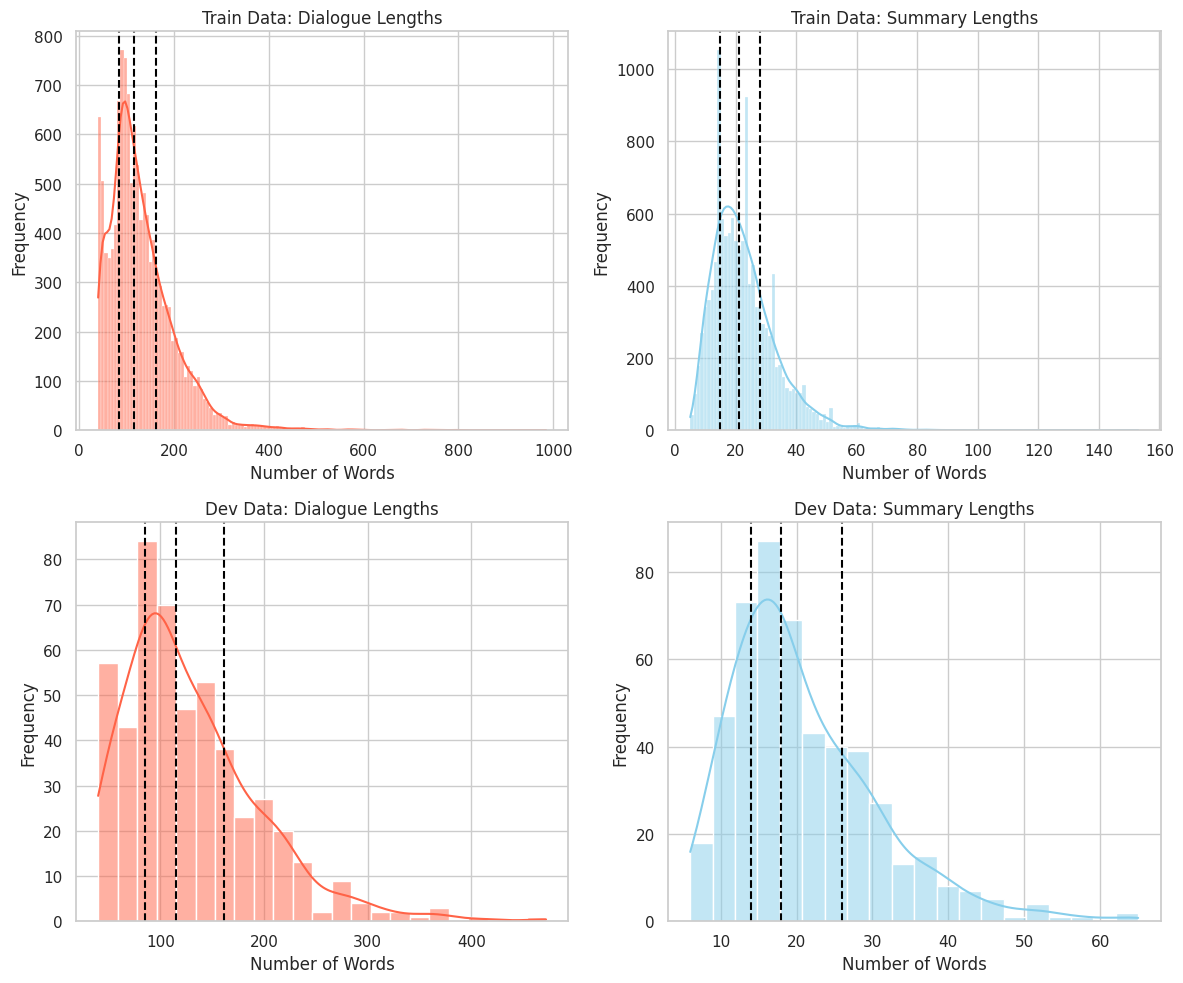

In [4]:
# Calculate quantiles
quantiles_dialogue_train = train_df['Dialogue Length'].quantile([0.25, 0.5, 0.75])
quantiles_summary_train = train_df['Summary Length'].quantile([0.25, 0.5, 0.75])

quantiles_dialogue_dev = dev_df['Dialogue Length'].quantile([0.25, 0.5, 0.75])
quantiles_summary_dev = dev_df['Summary Length'].quantile([0.25, 0.5, 0.75])

# Plotting
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(12, 10))

# Subplots for Training Data
plt.subplot(2, 2, 1)
sns.histplot(train_df['Dialogue Length'], kde=True, color='tomato')
plt.title('Train Data: Dialogue Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
for quantile in quantiles_dialogue_train:
    plt.axvline(quantile, color='black', linestyle='--')

plt.subplot(2, 2, 2)
sns.histplot(train_df['Summary Length'], kde=True, color='skyblue')
plt.title('Train Data: Summary Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
for quantile in quantiles_summary_train:
    plt.axvline(quantile, color='black', linestyle='--')

# Subplots for Development Data
plt.subplot(2, 2, 3)
sns.histplot(dev_df['Dialogue Length'], kde=True, color='tomato')
plt.title('Dev Data: Dialogue Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
for quantile in quantiles_dialogue_dev:
    plt.axvline(quantile, color='black', linestyle='--')

plt.subplot(2, 2, 4)
sns.histplot(dev_df['Summary Length'], kde=True, color='skyblue')
plt.title('Dev Data: Summary Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
for quantile in quantiles_summary_dev:
    plt.axvline(quantile, color='black', linestyle='--')

plt.tight_layout()
plt.show()

In this paper, we conducted a rigors statistical analysis of the DialogSum dataset to better understand the distribution characteristics of dialogue and summary lengths. This dataset contains dialogues and summaries that have been separated into training and development (Dev) sets. The descriptive statistics for both sets are as follows:

- **Training Set**: - Average Dialogue Length: 130.99 words, 70.98 words.
  - Average summary length: 22.87 words; 10.71 words on average.

- **Development Set**: - Average Dialogue Length: 129.34 words, 66.14 words.
  - Average summary length: 20.91 words; 9.77 words on average.


The lengths of dialogues and summaries vary greatly, as evidenced by these numbers. The length of dialogues is notably greater than that of summaries. The histograms of these datasets share the following characteristics:

- **Training Set**: - The distribution of dialogue lengths is skewed to the right, with the majority of dialogues consisting between 100 and 200 words, indicating a preference for shorter dialogues and fewer instances of longer dialogues.
  - The average length of a summary is between 10 and 30 words, with a right-skewed distribution.

- **Development Set**: - The development set has comparable characteristics, albeit with somewhat different mean and standard deviation values.

This distributional analysis is critical for our experiment since it effects the development of our summarization models. It suggests an optimum summary length range based on human annotations in the dataset. By modifying our algorithms to generate summaries within this range, which is reflective of the human-annotated summaries in the DialogSum dataset, we seek to strike a balance between conciseness and informativeness.


### Most Common Unigrams

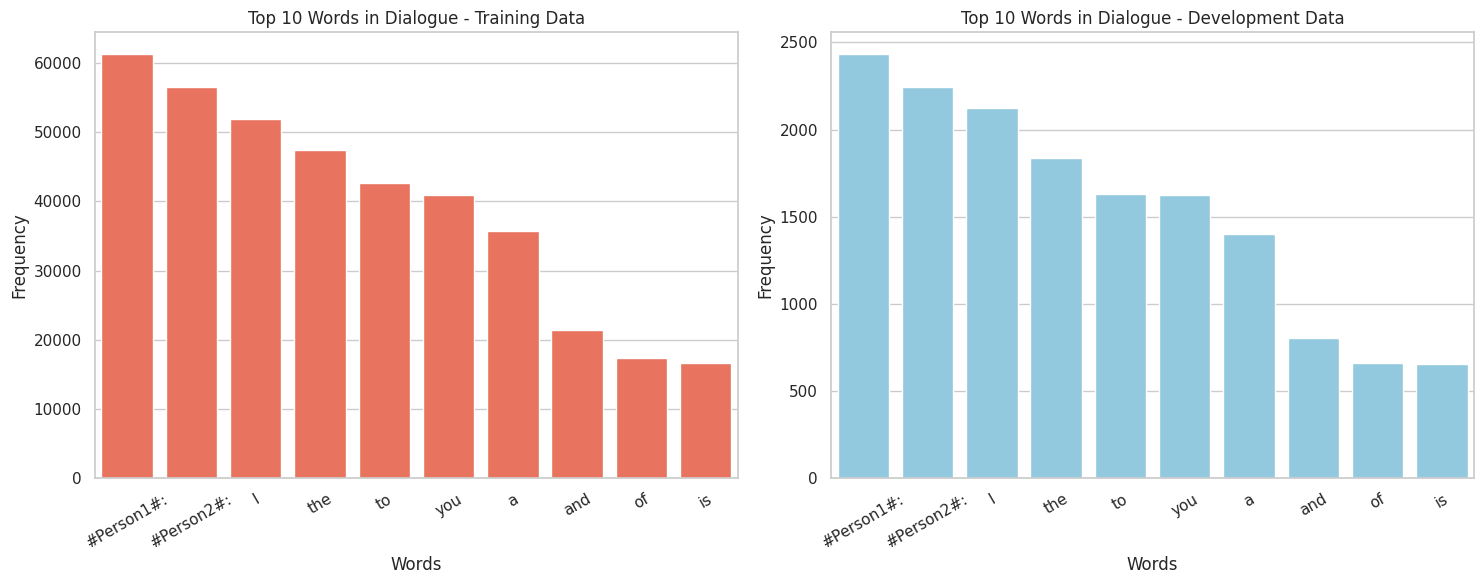

In [5]:
# Count word frequencies for the training dataset
word_counts_train = Counter(" ".join(train_df['dialogue']).split())
most_common_words_train = word_counts_train.most_common(10)
words_train, counts_train = zip(*most_common_words_train)

# Count word frequencies for the development dataset
word_counts_dev = Counter(" ".join(dev_df['dialogue']).split())
most_common_words_dev = word_counts_dev.most_common(10)
words_dev, counts_dev = zip(*most_common_words_dev)

# Plotting
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(15, 6))

# Subplot for Training Data
plt.subplot(1, 2, 1)
sns.barplot(x=list(words_train), y=list(counts_train), color="tomato")
plt.title('Top 10 Words in Dialogue - Training Data')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=30)

# Subplot for Development Data
plt.subplot(1, 2, 2)
sns.barplot(x=list(words_dev), y=list(counts_dev), color="skyblue")
plt.title('Top 10 Words in Dialogue - Development Data')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

A significant trend emerges in the frequency distribution of unigrams when the DialogSum dataset is examined. The most often identified words are: #Person1# #Person2#
I the to you and an of is
Several significant elements of the dataset and dialogue summaries are revealed by this distribution:
Markers for Conversation: The predominance of #Person1# and #Person2# emphasises the corpus's dialogic nature. These placeholders most likely represent two sides' conversational turns, emphasising the interactive and turn-taking nature of the talks.
First-person Account: The frequent use of the pronoun I emphasises the first-person perspective that is typical in talks. This implies that personal experiences, ideas, or actions are important in these interactions, which is an important factor when summarising.


A significant trend emerges in the frequency distribution of unigrams when the DialogSum dataset is examined. The most often identified words are:

1. `#Person1#`
2. `#Person2#`
3. `I`
4. `the`
5. `to`
6. `you`
7. `and`
8. `a`
9. `of`
10. `is`

This distribution reveals several key aspects of the dataset and dialogue summarization:

1. **Markers for Conversation:** The predominance of #Person1# and #Person2# emphasises the corpus's dialogic nature. These placeholders most likely represent two sides' conversational turns, emphasising the interactive and turn-taking nature of the talks.

2. **First-Person Perspective**: The frequent use of the pronoun I emphasises the first-person perspective that is typical in talks. This implies that personal experiences, ideas, or actions are important in these interactions, which is an important factor when summarising.

3. **Function Words**: The prevalence of function words such as `the`, `to`, `you`, `and`, `a`, `of`, and `is` aligns with spoken English expectations, where such words are employed to frame conversation and convey basic relations and syntax.

4. **Summarization Implications**: While these common words are important for understanding the structure and flow of dialogues, they may not add much to the content of a summary. This suggests that efficient summarization models for this dataset should concentrate on extracting the essence of the dialogue, potentially with less emphasis on these high-frequency but low-information phrases.

5. **Dataset Characteriszation**: The high frequency of these phrases characterises the dataset. It implies that the dialogues are most likely everyday talks between two people, with a mix of subjective (first-person) and objective (descriptive) parts.

Finally, an examination of the most prevalent unigrams in the DialogSum dataset provides significant insights into the nature of the dialogues and guides the construction of more effective summarising models. These findings highlight the necessity of focusing on meaningful content extraction rather than simply gathering often occuring but uninformative words.

### Uni-gram Overlap

In [6]:
# Function to calculate unigram overlap
def unigram_overlap(row):
    dialogue_words = set(row['dialogue'].split())
    summary_words = set(row['summary'].split())
    overlap = summary_words.intersection(dialogue_words)
    return len(overlap) / len(summary_words) * 100 if summary_words else 0

# Apply the function and calculate average for train_df
train_df['unigram_overlap'] = train_df.apply(unigram_overlap, axis=1)
avg_overlap_train = train_df['unigram_overlap'].mean()

# Apply the function and calculate average for dev_df
dev_df['unigram_overlap'] = dev_df.apply(unigram_overlap, axis=1)
avg_overlap_dev = dev_df['unigram_overlap'].mean()

# Create a styled DataFrame for display
results_df = pd.DataFrame({
    "Dataset": ["Training Set", "Development Set"],
    "Average Unigram Overlap (%)": [avg_overlap_train, avg_overlap_dev]
}).style.hide(axis="index")

# Display the styled DataFrame
display(results_df)

Dataset,Average Unigram Overlap (%)
Training Set,48.060675
Development Set,45.961782



These discoveries have a number of ramifications:

1. **Moderate Level of Overlap**: The percentages of unigram overlap in both sets are moderate. This level of overlap shows that, while there is some verbatim material transfer from the source dialogues to the summaries, a considerable fraction of the summaries are paraphrased or constructed from scratch.

2. **Indicative of Abstractive Summarization**: The average overlap of less than 50% indicates that the summaries in the dataset are primarily abstract. This suggests that the summaries rewrite, condense, or interpret the content rather than just extracting phrases or sentences from the talks.

3. **Stability Across Sets**: The similarity in overlap percentages between the training and development sets indicates that the summarization approach utilised across the dataset is consistent. This is useful for training machine learning models since it exhibits consistency in data features.

4. **Model creation Guidance**: The degree of unigram overlap can influence the creation of summarization models. Models should be able to capture the substance of the dialogues while also paraphrasing and compressing material in order to maintain a balance comparable to that observed in the dataset.

5. **Benchmark for Evaluation**: These percentages can be used to compare summarization models. A model that achieves a similar amount of unigram overlap may be deemed to be well aligned with the properties of the dataset's human-generated summaries.

6. **Content Representation**: The overlap percentage sheds light on the summaries' content representation. It implies that a substantial percentage of the content is portrayed differently than in the original discussions, emphasising the need of understanding and keeping context and intent in summary.

In conclusion, the examination of unigram overlap in the DialogSum dataset emphasises the abstractive character of summarization and provides essential insights for the creation and evaluation of automated summarization models. These findings highlight the significance of a model's capacity to extract crucial information while simultaneously paraphrasing and simply representing the core of the dialogues.



**Loading Test Set and Hidden Set**

In [7]:
# Reading Test Set and Hidden Set provided by DialogSum
test_df = pd.read_json("/content/drive/MyDrive/COMP9444/data/raw/dialogsum/dialogsum.test.jsonl", lines = True)[['dialogue', 'summary1']]
test_df.columns = ['dialogue', 'summary']
test_dialogues, references = list(test_df['dialogue']), list(test_df['summary'])

hidden_dialogues = list(pd.read_json('/content/drive/My Drive/COMP9444/data/raw/dialogsum/dialogsum.hiddentest.dialogue.jsonl', lines = True)['dialogue'])


## Methodology

### Overview of Transformer Technology in NLP

Transformers represent a paradigm shift in Natural Language Processing (NLP), significantly advancing the capability to process and understand long sequences of data. Their central innovation, the attention mechanism, enables context-rich interpretation of language by allowing for the simultaneous processing of whole sequences. This is a significant advance over previous models such as LSTMs and RNNs, which process data sequentially and frequently struggle with long-term dependencies.

#### Transformers vs. LSTMs and RNNs:
- **Contextual Interpretation**: In contrast to LSTMs and RNNs, which are intrinsically sequential and limited in their ability to capture bidirectional context, Transformers understand entire sequences holistically. This allows them to better perceive contextual nuances.
- **Scalability and Efficiency**: Transformers' parallel processing capacity makes them more scalable and efficient, particularly for applications involving huge datasets.

### Transformer Model Architecture

Transformer models, which are central to our research, have an encoder-decoder structure.

#### Encoder:
- **Function**: It converts input sequences into continuous representations, encapsulating the context of the input.
- **Construction**: Each layer in the encoder is made up of two sub-layers and comprises of several identical layers. The first is a multi-head self-attention mechanism, and the second is a basic feed-forward network with positional connections.
- **Residual Connections and Normalisation**: Each sub-layer has a residual connection, followed by layer normalisation, which helps to mitigate the vanishing gradient problem in deep networks.

#### Decoder:
- **Function**: The decoder constructs the output text sequence using the encoder's representations.
- **Autoregressive Nature**: It functions in an autoregressive fashion, predicting the next token in the sequence using the encoder's output and prior outputs.
- **Another Layer**: A third sub-layer in the decoder performs multi-head attention over the encoder's output. Each sub-layer in the decoder, like the encoder, is followed by residual connections and layer normalisation.

### Mechanism of Attention

The Transformer architecture is built around the attention mechanism, which allows the model to focus on different elements of the input sequence when generating each word of the output sequence.

### Dialogue Summarization Relevance

These architectural components of Transformer models become critical in the context of dialogue summarization. Transformers' ability to comprehend context-rich information, as well as the flexibility given by their attention processes, are especially useful for summarising complex, multi-threaded interactions. Our study will look into how these characteristics of Transformer-based models, particularly when compared to static embedding-based Seq2Seq models, contribute to the success of dialogue summarization.

**Helper Functions**

In [8]:
# Helper function for Data Collator
def get_feature(batch, tokenizer):
  encodings = tokenizer(batch['dialogue'], text_target=batch['summary'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

# Generate summary from the outputs of transformers
def generate_summaries(texts, model, tokenizer, device, progress = True):
    model.to(device)
    model.eval()
    summaries = []
    if progress:
        iterator = tqdm(texts)
    else:
        iterator = texts
    for text in iterator:
        with torch.no_grad():
            inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True).to(device)
            summary_ids = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], min_length=15, max_length = 30)
            summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
            summaries.append(summary)

    return summaries

# Calculates performance metrics for each generated summary against the reference summary
def generate_metrics(references, summaries):
    total_rouge_scores = {key: 0 for key in ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']}
    total_bleu_score = 0

    rouge_metric = load_metric('rouge')

    for reference, summary in tqdm(zip(references, summaries), total=len(references)):

        # Calculate ROUGE scores
        rouge_score = rouge_metric.compute(predictions=[summary], references=[reference])

        # Aggregate ROUGE scores
        for key in total_rouge_scores.keys():
            total_rouge_scores[key] += rouge_score[key].mid.fmeasure

        # Calculate BLEU score
        bleu_score = sentence_bleu([nltk.word_tokenize(reference)], nltk.word_tokenize(summary))
        total_bleu_score += bleu_score

    # Average the scores
    scores = {}
    for k, v in total_rouge_scores.items():
        scores[k] = scores.get(k, 0) + v/len(test_dialogues)

    avg_bleu_score = total_bleu_score / len(test_dialogues)
    scores = list(scores.values())
    scores.append(avg_bleu_score)
    return scores


### Custom Seq2Seq Model

#### Data Preparation

##### Normalisation and Tokenisation

Preprocessing for the DialogSum dataset, which is intrinsically clean and error-free, consists primarily of prepping the text for conversion into embeddings. This is accomplished through the use of the NLTK's WordPunctTokenizer. This tokenizer selection is significant for various reasons:

- **Granular Tokenization**: WordPunctTokenizer provides granular tokenization, which breaks down text into words and punctuation, which is critical for capturing syntactical nuances in dialogues.
- **Static Embedding Compatibility**: The adoption of NLTK's tokenizer over more complex tokenizers such as Byte Pair Encoding (BPE), which is employed in models such as BART, is consistent with the project's emphasis on static embeddings. While BPE is robust and capable of collecting subword tokens, it may pose complications that are not compatible with static embedding approaches.


##### Handling Contractions

A custom function `fix_contractions` is employed to expand contractions in the text. This is an important step since contractions might cause discrepancies in tokenization and embeddings. To ensure consistency in representation, "don't" should preferably be expanded to "do not".

##### Text Cleaning and Standardisation

To further standardise the text format, further cleaning stages are implemented:
- Special placeholders such as `#person1#` are formatted uniformly to maintain consistency.
- To maintain conventional text formatting, spaces preceding punctuation marks are omitted.
- To maintain tokenization consistency, the text is transformed to lowercase.


##### Tensor Conversion

For each debate and its related summary, the tokenized text is converted into tensors, which are subsequently utilised as inputs to the model. This translation is critical because it converts the preprocessed text into a numerical format that neural networks can process.

- **Indexing Words**: The function `indexesFromSentence` maps each word in a sentence to its matching index in a predetermined dictionary, making text conversion easier.
- **Tensor Creation**: The `tensorFromSentence` function turns these indices into tensors by inserting an end-of-sentence (EOS) token to indicate the end of a sequence.

##### DataLoader Development

The final stage in data preparation is to build a DataLoader, which is essential for batch processing during model training:
- **Batch Operations**: The DataLoader enables efficient batch data processing, which is critical for training on big datasets.
- **Padding and Sampling**: Padding is utilised to provide uniform sequence lengths, and batching is done with a random sampler, allowing for stochastic optimisation during training.

##### Model Training Implications

This preprocessing pipeline has been rigorously constructed to guarantee that the data is in the best possible format for training the suggested models. This approach builds a solid foundation for effectively training models on the DialogSum dataset by meticulously tokenizing, normalising, and transforming the language into a machine-readable format. The importance placed on compatibility with static embeddings and attention to detail in text normalization reflects a thorough understanding of the requirements for successful dialogue summarization.
**Helper functions**

In [9]:
# Expands contractions
def fix_contractions(text):
    with open('/content/drive/My Drive/COMP9444/data/contractions.json', 'r') as f:
        contractions = json.load(f)
    tokens = text.split()
    cleaned = []
    for token in tokens:
        cleaned.append(contractions.get(token, token))
    return ' '.join(cleaned)

# Tokenises text using WordPunctTokenizer and normalises text
def tokenize(text):
    tokenizer = WordPunctTokenizer()
    text = fix_contractions(text)
    tokens = tokenizer.tokenize(text)
    text = ' '.join(tokens).lower()
    text = text.replace('# person1 #', '#person1#')
    text = text.replace('# person2 #', '#person2#')
    text = text.replace('# person3 #', '#person3#')
    text = text.replace('# person4 #', '#person4#')
    text = text.replace('# person5 #', '#person5#')
    text = text.replace('# person6 #', '#person6#')
    text = text.replace('# person7 #', '#person7#')
    text = text.replace(' ,', ',')
    text = text.replace(' .', '.')
    text = text.replace(' ?', '?')
    text = text.replace(' !', '!')
    text = text.replace(" ' ", "'")
    text = text.replace("< ", "<")
    text = text.replace(" >", ">")
    return text.split()

# Creates a pairs of original dialogue and its summary
def prepareData(src, trg):
    dial = np.array(src)
    summary = np.array(trg)
    pairs = [[dial[i], summary[i]] for i in range(len(dial))]
    return pairs

# Converts sentences into list of word indices
def indexesFromSentence(sentence):
    return [dictionary.get(word) for word in tokenize(sentence) if word in dictionary.keys()]

# Converts the list of word ids for each sentence into a pytorch tensor
def tensorFromSentence(sentence):
    indexes = indexesFromSentence(sentence)
    indexes.append(EOS_TOKEN)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

# Creates Tensors from pairs of dialogue and summary
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(pair[0])
    target_tensor = tensorFromSentence(pair[1])
    return (input_tensor, target_tensor)

# Creates DataLoader Object
def get_dataloader(pairs, batch_size):

    num_pairs = len(pairs)

    input_ids = np.full((num_pairs, MAX_LENGTH), PAD_IDX, dtype=np.int32)
    target_ids = np.full((num_pairs, MAX_LENGTH), PAD_IDX, dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(inp)
        tgt_ids = indexesFromSentence(tgt)
        inp_ids.append(EOS_TOKEN)
        tgt_ids.append(EOS_TOKEN)
        input_ids[idx, :len(inp_ids)] = inp_ids[:MAX_LENGTH]
        target_ids[idx, :len(tgt_ids)] = tgt_ids[:MAX_LENGTH]

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(
        train_data, sampler=train_sampler, batch_size=batch_size)
    return train_dataloader

In [10]:
train_src_tokens = list(train_df['dialogue'].apply(lambda x: tokenize(x)))
train_trg_tokens = list(train_df['summary'].apply(lambda x: tokenize(x)))

dev_src_tokens = list(dev_df['dialogue'].apply(lambda x: tokenize(x)))
dev_trg_tokens = list(dev_df['summary'].apply(lambda x: tokenize(x)))

train_src = [' '.join(sent) for sent in train_src_tokens]
train_trg = [' '.join(sent) for sent in train_trg_tokens]

dev_src = [' '.join(sent) for sent in dev_src_tokens]
dev_trg = [' '.join(sent) for sent in dev_trg_tokens]

#### Embedding Matrix Exploration

##### Rationale for Using Word2Vec and GloVe
The decision to use Word2Vec embeddings improved with GloVe (Global Vectors for Word Representation) stems from the advantages of both methodologies:
- **Word2Vec's Mechanism**: Word2Vec captures semantic links between words by learning representations from the corpus's surrounding context. However, it may be limited in its ability to capture broader corpus-level word co-occurrence patterns.
- **GloVe's Corpus-Wide Context**: GloVe supplements Word2Vec by analysing global word-word co-occurrence statistics from a huge corpus, resulting in a more comprehensive understanding of latent contexts and token interactions.

#### Analysis of Embedding Matrices

##### Base Word2Vec Model

- **Query**: `#person1#`
- **Top Related Words**: Include 'perfect!', 'peking', 'speaking', etc.
- **Observation**: The base model associates `#person1#` primarily with adjectives and unrelated terms, demonstrating a lack of contextual understanding regarding dialogue participants.

##### GloVe-Enhanced Model

- **Query**: `person1`
- **Top Related Words**: Include 'person2', 'person3', 'person4', etc.
- **Observation**: GloVe embeddings showcase a significant improvement by relating `person1` to other dialogue entities (e.g., 'person2', 'person3'). This indicates a better grasp of the dialogic context, though it may introduce additional variance in the embeddings.

##### Finetuned Word2Vec on GloVe

- **Query**: `#person1#`
- **Top Related Words**: Include '#person2#', 'sam', 'lucy', etc.
- **Observation**: The finetuned model aptly identifies `#person1#` in relation to other participants in the dialogue ('#person2#', '#person3#', and specific names). This result aligns closely with the desired outcome for dialogue summarization, suggesting an enhanced understanding of the relational dynamics in conversations.

##### Implications for Dialogue Summarization

The iterative process of constructing the embedding matrix offers important insights:
- **Contextual Relevance**: The progression from the fundamental Word2Vec model to a GloVe-enhanced and then finetuned model highlights the importance of contextual relevance in embeddings for dialogue summarization.
- **Balancing Specificity and Generality**: Whereas the GloVe model gives a broad knowledge of relationships, the fine-tuned Word2Vec model finds a balance by retaining specific relational dynamics relevant to dialogues.
- **Targeted Word Representations**: The fine-tuned model's ability to tightly correlate dialogue markers like '#person1#' with other participants implies a targeted grasp of conversational structures, which is required for effective summarization.

#### Conclusion

This study's investigation of embedding matrices emphasises the need of correctly chosen word representations in dialogue summarization. The project develops an embedding matrix that accurately reflects the relationship dynamics within dialogues by leveraging the strengths of both Word2Vec and GloVe, as well as finetuning. This is a key component of the model that will improve the accuracy and relevancy of the generated summaries.
**Code used to generate the cleaned corpus for Word2Vec Model**
```python
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
import json


def combine_columns(row):
    try:
        return row['dialogue'] + ' ' + row['summary']
    except RuntimeError:
        print("PandasDataFrameNotFound")


def fix_contractions(text):
    with open('../data/contractions.json', 'r') as f:
        contractions = json.load(f)
    tokens = text.split()
    cleaned = []
    for token in tokens:
        cleaned.append(contractions.get(token, token))
    return ' '.join(cleaned)


def tokenize(text):
    tokenizer = WordPunctTokenizer()
    text = fix_contractions(text)
    tokens = tokenizer.tokenize(text)
    text = ' '.join(tokens).lower()
    text = text.replace('# person1 #', '#person1#')
    text = text.replace('# person2 #', '#person2#')
    text = text.replace('# person3 #', '#person3#')
    text = text.replace('# person4 #', '#person4#')
    text = text.replace('# person5 #', '#person5#')
    text = text.replace('# person6 #', '#person6#')
    text = text.replace('# person7 #', '#person7#')
    text = text.replace(' ,', ',')
    text = text.replace(' .', '.')
    text = text.replace(' ?', '?')
    text = text.replace(' !', '!')
    text = text.replace(" ' ", "'")
    text = text.replace("< ", "<")
    text = text.replace(" >", ">")
    return text


if __name__ == '__main__':
    train = pd.read_json(
        '../data/raw/dialogsum/dialogsum.train.jsonl', lines=True)
    train['summary'] = train['summary'].apply(
        lambda x: '<SOS> ' + x + ' <EOS>')

    corpus = train.apply(combine_columns, axis=1)
    corpus = list(map(tokenize, corpus))
    train_corpus = '\n'.join(corpus)

    with open("../data/processed/train_corpus", "w") as f:
        f.write(train_corpus)
    print('Training Corpus Generated')
    dev = pd.read_json(
        '../data/raw/dialogsum/dialogsum.dev.jsonl', lines=True)
    dev['summary'] = dev['summary'].apply(
        lambda x: '<SOS> ' + x + ' <EOS>')

    dev_corpus = dev.apply(combine_columns, axis=1)
    dev_corpus = list(map(tokenize, dev_corpus))
    dev_corpus = '\n'.join(dev_corpus)
    with open("../data/processed/dev_corpus", "w") as f:
        f.write(dev_corpus)
    corpus.append(dev_corpus)
    print('Dev Corpus Generated')

    test = pd.read_json(
        '../data/raw/dialogsum/dialogsum.test.jsonl', lines=True)[['dialogue', 'summary1']]
    test.columns = ['dialogue', 'summary']
    test['summary'] = test['summary'].apply(
        lambda x: '<SOS> ' + x + ' <EOS>')

    test_corpus = test.apply(combine_columns, axis=1)
    test_corpus = list(map(tokenize, test_corpus))
    test_corpus = '\n'.join(test_corpus)
    corpus.append(test_corpus)
    corpus = '\n'.join(corpus)
    print('Test Corpus Generated')

    with open("../data/processed/glove_corpus", "w") as f:
        f.write(corpus)

    print('GloVe Corpus Generated')
```

**Code used to generate the finetuned embeddings**
```python
# Loads the GloVe embedding in the Word2Vec word_vector format
def load_glove_model(glove_file_path):
    glove_model = KeyedVectors.load_word2vec_format(glove_file_path, binary=False, no_header=True)
    return glove_model

def get_corpus():
    with open("/content/drive/My Drive/COMP9444/data/processed/glove_corpus", "r") as f:
        sentences = f.readlines()
    return sentences

sentences = get_corpus()
tokens = [sent.split() for sent in sentences]

# Base model
base_model = Word2Vec(vector_size=300, min_count = 20, epochs=20)
base_model.build_vocab(tokens)
total_examples = base_model.corpus_count

# Initiliasing Fine-tuned Model
fine_model = Word2Vec(vector_size=300, min_count = 20, epochs=20)
fine_model.build_vocab(tokens)

corpus_path = "/content/drive/My Drive/COMP9444/embeds/GloVe/glove.840B.300d.txt'
corpus_model = load_glove_model(corpus_path)

#Retraining the weights of a Word2Vec Model
fine_model.build_vocab([list(corpus_model.key_to_index.keys())], update=True)
fine_model.train(tokens, total_examples=total_examples, epochs=fine_model.epochs)
fine_model_wv = fine_model.wv

# Saving the finetuned model
fine_model_wv.save_word2vec_format('/content/drive/My Drive/COMP9444/models/GloVe-Word2Vec/glove.bin')
```

In [11]:
# Load the word vectors from the pre-trained model file.
word_vectors = KeyedVectors.load_word2vec_format(
        '/content/drive/My Drive/COMP9444/models/GloVe-Word2Vec/glove.bin')

# Define special tokens used in the model.
pad_token = "<pad>"
sos_token = "<sos>"
eos_token = "<eos>"

# Check if the padding token is already in the word vector keys.
# If not, add it and update the corresponding indices.
if pad_token not in word_vectors.key_to_index:
    pad_index = len(word_vectors)
    word_vectors.key_to_index[pad_token] = pad_index
    word_vectors.index_to_key.append(pad_token)
else:
    pad_index = word_vectors.key_to_index[pad_token]

# Store the index of the padding token.
PAD_IDX = pad_index

# Store the indices of the start-of-sentence and end-of-sentence tokens.
SOS_TOKEN = word_vectors.key_to_index['<sos>']
EOS_TOKEN = word_vectors.key_to_index['<eos>']

# Create a list of vocabulary words from the word vectors.
vocab = list(word_vectors.key_to_index.keys())

# Determine the size of the vocabulary.
vocab_size = len(vocab)

# Get the embedding dimension from the vector of the '<sos>' token.
embedding_dim = word_vectors.get_vector('<sos>').shape[0]

# Create a dictionary for quick lookup of word indices.
dictionary = word_vectors.key_to_index

# Initialize an embedding matrix with zeros. This matrix will be filled with the word vectors.
embedding_matrix = torch.zeros(vocab_size, embedding_dim)

# Populate the embedding matrix with the vectors of each word in the vocabulary.
for i, word in enumerate(vocab):
    if word == pad_token:
        continue
    embedding_matrix[i] = torch.Tensor(np.array(word_vectors[word]))

# Move the embedding matrix to the appropriate device (e.g., GPU if available).
embedding_matrix = embedding_matrix.to(device)



#### Model Architecture for Dialogue Summarization

##### EncoderRNN

- **Design**: The EncoderRNN is a key component that is responsible for converting input sequences into continuous representations. A bidirectional GRU (Gated Recurrent Unit) is used in its architecture to capture contextual information from both directions of the input sequence.
- **Embeddings**: The model can use pre-trained embeddings, as indicated by the presence of an embedding matrix, to improve its understanding of nuanced language patterns.
- **Layer Normalisation and Dropout**: Using dropout and layer normalisation makes the model more resistant to overfitting and enhances training stability.

##### Bahdanau Attention (Attention Mechanism)

- **Function**: The BahdanauAttention module is built into the model and allows the decoder to concentrate on certain parts of the input sequence when creating each word in the summary.
- **Implementation**: This attention method computes attention scores via a linear transformation of the hidden states (query and keys), followed by a `softmax` to obtain weights.

##### AttnDecoderRNN

- **Design**: This component is in charge of creating the summary from the encoded representations, using the Bahdanau attention mechanism to focus on key parts of the input.
- **GRU with Attention**: The model can generate contextually rich summaries by combining GRU with attention.
- **Output Generation**: The model's output layer converts the decoder's output to the required output size, which is most often the vocabulary size.

##### Implications for Dialogue Summarization

The architecture suggested here is well-suited to the complexity of abstractive dialogue summarization:

- **Bidirectional Contextual grasp**: The EncoderRNN's bidirectional nature allows for a thorough grasp of the dialogue context.
- **Focused summarising**: The attention mechanism guarantees that the model focuses on the most important sections of the discourse, which is critical for good summarising.
- **Robustness and Stability**: Dropout, layer normalisation, and early stopping all contribute to the model's robustness by preventing overfitting and guaranteeing stable training.
- **Customization and Flexibility**: The ability to include pre-trained embeddings, as well as the configurable nature of the GRU and attention mechanism, enable flexibility, allowing the model to be adapted to unique discourse characteristics.

##### Conclusion

The EncoderRNN, AttnDecoderRNN with Bahdanau attention mechanism architecture provides a comprehensive solution to abstractive dialogue summarization. This design is poised to capture the intricacies of discussions and provide coherent, contextually relevant summaries, solving the inherent difficulties of abstractive summarization in NLP.


**Note: Initial guidance was taken from various sources to build this model and among them [this](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) has influenced us the most. We have from there changed our architecture significantly by adding important features like making the model `bidirectional`, stacking more `layers`, changing the `optimiser` and `criterion` for loss. These changes were all driven by strong research.**



In [12]:
# Encoder for our Custom Seq2Seq Encoder-Decoder model
class EncoderRNN(nn.Module):
    # Initialization of the EncoderRNN class
    def __init__(self, input_size, hidden_size, num_layers, embedding_matrix=None, bidirectional=True, freeze=True, dropout_p=0.05):
        super(EncoderRNN, self).__init__()
        # Encoder parameters
        self.hidden_size = hidden_size  # Size of the hidden layers
        self.num_layers = num_layers  # Number of layers in GRU
        self.num_directions = 2 if bidirectional else 1  # Set to 2 for bidirectional, otherwise 1
        self.bidirectional = bidirectional  # Whether the GRU is bidirectional
        self.layer_norm = nn.LayerNorm(hidden_size)  # Layer normalization for stability

        # Embedding layer
        if embedding_matrix is not None:
            # Use pre-trained embeddings if provided
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze, padding_idx=PAD_IDX)
        else:
            # Otherwise, initialize embeddings
            self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=PAD_IDX)

        # GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=self.bidirectional)
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_p)

    # Forward pass of the encoder
    def forward(self, input):
        # Embedding and dropout application
        embedded = self.dropout(self.embedding(input))
        # Pass through GRU
        output, hidden = self.gru(embedded)

        # If bidirectional, combine the outputs and hidden states from both directions
        if self.bidirectional:
            batch, seq_len, _ = output.shape
            output = output.view((batch, seq_len, self.num_directions, self.hidden_size))
            hidden = hidden.view(self.num_layers, self.num_directions, batch, self.hidden_size)
            output = output[:, :, 0, :] + output[:, :, 1, :]
            hidden = hidden[:, 0, :, :] + hidden[0, 1, :, :]

        # Apply layer normalization
        output = self.layer_norm(output)

        return output, hidden

# Attention Layer
class BahdanauAttention(nn.Module):
    # Initialization of the BahdanauAttention class
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        # Attention network layers
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    # Forward pass of the attention mechanism
    def forward(self, query, keys):
        # Compute scores
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        # Compute attention weights
        weights = F.softmax(scores, dim=-1)
        # Compute context vector as weighted sum of keys
        context = torch.bmm(weights, keys)

        return context, weights

# Decoder Layer with support for Attention for our Custom Seq2Seq Encoder-Decoder model
class AttnDecoderRNN(nn.Module):
    # Initialization of the AttnDecoderRNN class
    def __init__(self, hidden_size, output_size, num_layers, embedding_matrix=None, freeze=True, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        # Embedding layer
        if embedding_matrix is not None:
            # Use pre-trained embeddings if provided
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze, padding_idx=PAD_IDX)
        else:
            # Otherwise, initialize embeddings
            self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=PAD_IDX)
        # Attention mechanism
        self.attention = BahdanauAttention(hidden_size)
        # GRU layer
        self.gru = nn.GRU(2 * hidden_size, hidden_size, num_layers, batch_first=True)
        # Output layer
        self.out = nn.Linear(hidden_size, output_size)
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_p)
        # Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_size)

    # Forward pass of the decoder
    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        # Initialize input with Start Of Sequence token
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_TOKEN)
        # Set initial hidden state
        decoder_hidden = encoder_hidden
        # Lists to store outputs and attention weights
        decoder_outputs = []
        attentions = []

        # Loop for each step in the sequence
        for i in range(MAX_LENGTH):
            # Perform a single decoding step
            decoder_output, decoder_hidden, attn_weights = self.forward_step(decoder_input, decoder_hidden, encoder_outputs)
            # Append output and attention weights
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            # Update next input token
            if target_tensor is not None and i < target_tensor.size(1):
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Use the predicted token as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        # Combine outputs and compute log-softmax
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        # Combine attentions
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    # Performs a single forward step of the decoder
    def forward_step(self, input, hidden, encoder_outputs):
        # Embedding and dropout application
        embedded = self.dropout(self.embedding(input))
        # Last layer hidden state
        last_layer_hidden = hidden[-1].unsqueeze(0)
        # Query formation
        query = last_layer_hidden.permute(1, 0, 2)
        # Compute context and attention weights
        context, attn_weights = self.attention(query, encoder_outputs)
        # Concatenate context with embedded input
        input_gru = torch.cat((embedded, context), dim=2)
        # Pass through GRU
        output, hidden = self.gru(input_gru, hidden)
        # Pass through output layer and apply layer normalization
        output = self.out(self.layer_norm(output))

        return output, hidden, attn_weights

**Helper functions**

In [13]:
# EarlyStopping class to prevent overfitting by monitoring validation loss.
class EarlyStopping:
    # Initialize the EarlyStopping object.
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience  # Number of epochs to wait before stopping if no improvement.
        self.counter = 0         # Counter for tracking epochs without improvement.
        self.best_loss = None    # Best loss observed so far.
        self.early_stop = False  # Flag to indicate if early stopping is triggered.
        self.delta = delta       # Minimum change to signify an improvement.

    # Method to be called after each epoch to check if early stopping is triggered.
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss  # Set the first validation loss as the best loss.
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1  # Increment counter if no significant improvement.
            if self.counter >= self.patience:
                self.early_stop = True  # Trigger early stopping if patience is exceeded.
        else:
            self.best_loss = val_loss  # Update best loss if improvement is found.
            self.counter = 0           # Reset counter if improvement is found.


# Function to perform a single training epoch.
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
                decoder_optimizer, criterion):

    total_loss = 0  # Variable to store total loss for the epoch.
    for data in dataloader:  # Iterate over each batch in the dataloader.
        input_tensor, target_tensor = data  # Unpack the batch data.

        # Zero gradients for both optimizers.
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Forward pass through the encoder.
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        # Forward pass through the decoder.
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        # Calculate loss between output and target tensor.
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()  # Perform backpropagation.

        # Update weights for both encoder and decoder.
        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()  # Accumulate loss for the epoch.

    return total_loss / len(dataloader)  # Return average loss for the epoch.


# Function to perform a single validation epoch.
def validate_epoch(dataloader, encoder, decoder, criterion):
    total_loss = 0  # Variable to store total loss for the epoch.
    with torch.no_grad():  # Disable gradient calculations for validation.
        for data in dataloader:  # Iterate over each batch in the dataloader.
            input_tensor, target_tensor = data  # Unpack the batch data.

            # Forward pass through the encoder and decoder without gradients.
            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

            # Calculate loss between output and target tensor.
            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.view(-1)
            )

            total_loss += loss.item()  # Accumulate loss for the epoch.

    return total_loss / len(dataloader)  # Return average loss for the epoch.




#### Training Loop

#### Selection of AdamW Optimizer

- **AdamW Characteristics**: A version of the original `Adam` optimizer, the AdamW optimizer is distinguished by its effective handling of sparse gradients and adaptable learning rates for different parameters. In contrast to Adam, AdamW decouples weight decay from gradient updates, which can lead to improved training stability and performance, particularly in complicated models.
- **Application for Abstractive Summarization**: Given the complexities of abstractive summarization, which necessitates a nuanced grasp of language and context, `AdamW`'s adaptive learning rate method is an excellent fit. It allows the model to modify learning rates for different parameters, which is critical for properly understanding the complicated patterns in dialogue data.

#### Selection of Loss Function: CrossEntropyLoss

- **Criterion**: The criterion used, `nn.CrossEntropyLoss`, is critical for classification tasks, which are fundamentally the nature of language synthesis in summarization. This loss function computes the difference between the predicted and actual probabilities (word in this context).
  
- **Handling Padding**: The `ignore_index=PAD_IDX` argument stands out. Padding tokens are used in sequence generation activities to make all sequences in a batch the same length. These padding tokens, however, should have no effect on the loss computation. Setting `ignore_index` to the padding token index (`PAD_IDX`) essentially ignores these tokens in loss computation, ensuring the model concentrates on significant textual content rather than padded sequences.

#### Hyperparameter Selection

- **Learning Rate and Momentum**: A learning rate of `3e-4`, coupled with a momentum factor of `0.9`, strikes a balance between rapid convergence and stability in the learning process. The chosen learning rate is neither too high to cause overshooting of the global minimum nor too low to slow down the training excessively. The momentum term helps in accelerating the optimizer in the relevant direction and dampens oscillations.

- **Early Stopping**: Incorporating an `EarlyStopping` mechanism with a patience of `3 epochs` and a delta of `0.01` provides a robust way to prevent overfitting. This is particularly important in abstractive summarization where the risk of overfitting to the training data can lead to poor generalization on unseen dialogues.


#### Implications of Loss Function in Model Training

- **Model's Learning Focus**: Using `CrossEntropyLoss`, the model's learning objectives are aligned with the task at hand, accurately predicting the next word in the summary. This loss function ensures that the model's predictions are based on probability, with the goal of increasing the likelihood of the correct next word.
  
- **Impact on Training Dynamics**: Ignoring padding in the loss computation helps to retain the training process's integrity. It prevents the model from 'cheating' the training by learning to accurately predict padding tokens, which are plentiful but uninformative.

The training loop for the abstractive summarization model is adeptly tuned for the task's challenges, incorporating the `AdamW` optimizer, carefully chosen hyperparameters, and `CrossEntropyLoss` with padding exclusion. It guarantees that the model not only learns the subtle patterns found in dialogue data, but that its learning is also aligned with the actual informative content of the talks, boosting its capacity to provide coherent and contextually appropriate summaries.


In [14]:
# Initialize the training function with data loaders, models, number of epochs, learning rate, and momentum.
def train(train_dataloader, val_dataloader, encoder, decoder, n_epochs, learning_rate=3e-4, momentum=0.9):

    # Define the model type based on the number of layers in the encoder.
    model_type = "Final" if encoder.num_layers > 1 else "Lite"

    # Initialize optimizers for both encoder and decoder using the AdamW optimizer.
    encoder_optimizer = optim.AdamW(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate)

    # Define learning rate schedulers for both encoder and decoder to adjust the learning rate over time.
    scheduler_encoder = optim.lr_scheduler.StepLR(encoder_optimizer, step_size=10, gamma=0.5)
    scheduler_decoder = optim.lr_scheduler.StepLR(decoder_optimizer, step_size=10, gamma=0.5)

    # Set the loss function to CrossEntropyLoss, ignoring the padding index in calculations.
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    # Initialize lists to keep track of training and validation losses.
    train_losses = []
    val_losses = []

    # Set an initial best loss value to infinity for comparison.
    best_loss = float('inf')

    # Initialize an early stopping mechanism to prevent overfitting.
    early_stopping = EarlyStopping(patience=3)

    # Iterate over the specified number of epochs.
    for epoch in tqdm(range(1, n_epochs + 1)):

        # Calculate training loss for the current epoch.
        train_loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

        # Calculate validation loss for the current epoch.
        val_loss = validate_epoch(val_dataloader, encoder, decoder, criterion)

        # Store the losses for analysis.
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Update the learning rate based on the scheduler.
        scheduler_encoder.step()
        scheduler_decoder.step()

        # Print the training and validation losses for the current epoch.
        print(f'Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

        # Save the model if it performs better on validation loss.
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(encoder.state_dict(), f'/content/drive/My Drive/COMP9444/models/Custom-{model_type}/encoder_best.pth')
            torch.save(decoder.state_dict(), f'/content/drive/My Drive/COMP9444/models/Custom-{model_type}/decoder_best.pth')

        # Check if early stopping should be triggered.
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Return the training and validation loss histories.
    return train_losses, val_losses

# Function to evaluate the model and generate summaries.
def evaluate(encoder, decoder, sentences):
    summaries = []
    attentions = []

    # Iterate through each sentence in the input.
    for sentence in sentences:
        with torch.no_grad():  # Disable gradient calculations for evaluation.
            input_tensor = tensorFromSentence(sentence)  # Convert the sentence to tensor.

            # Generate encoder outputs and hidden states.
            encoder_outputs, encoder_hidden = encoder(input_tensor)

            # Generate decoder outputs and attention weights.
            decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

            # Select the top word index from decoder outputs.
            _, topi = decoder_outputs.topk(1)
            decoded_ids = topi.squeeze()

            # Decode the indices to words.
            decoded_words = []
            for idx in decoded_ids:
                if idx.item() == EOS_TOKEN:  # Check for end of sentence token.
                    decoded_words.append('<eos>')
                    break
                decoded_words.append(vocab[idx.item()])

            # Compile the summary and store it.
            summaries.append(' '.join(decoded_words))
            attentions.append(decoder_attn)
    return summaries, attentions

# Function to count the number of trainable parameters in the model.
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#### Custom-Lite


In [15]:
hidden_size = 300
batch_size = 32
freeze = False # Freeze embedding layer

In [16]:
train_pairs = prepareData(train_src, train_trg)
val_pairs = prepareData(dev_src, dev_trg)

lite_train_dataloader = get_dataloader(train_pairs, batch_size) # Get DataLoader for training
lite_val_dataloader = get_dataloader(val_pairs, batch_size) # Get DataLoader for validation

In [17]:
# Encoder and Decoder
encoder_lite = EncoderRNN(input_size=vocab_size, hidden_size=hidden_size, num_layers=1, embedding_matrix=embedding_matrix, bidirectional=True, freeze=freeze).to(device)
decoder_lite = AttnDecoderRNN(hidden_size=hidden_size, output_size=vocab_size, num_layers=1, embedding_matrix=embedding_matrix, freeze=freeze).to(device)

In [18]:
# Calculating number of training parameters
total_params_encoder = count_trainable_parameters(encoder_lite)
total_params_decoder = count_trainable_parameters(decoder_lite)
total_params_attention = count_trainable_parameters(decoder_lite.attention)

total_trainable_params = total_params_encoder + \
        total_params_decoder+total_params_attention
print(f'Total trainable parameters for Custom-Lite: {total_trainable_params}')

Total trainable parameters for Custom-Lite: 7696838


In [19]:
# Training the Lite Model
train_losses, val_losses = train(lite_train_dataloader, lite_val_dataloader, encoder_lite, decoder_lite, 30)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, Train Loss: 5.04274933888362, Validation Loss: 4.358942896127701
Epoch 2, Train Loss: 4.148129175870847, Validation Loss: 3.99843867123127
Epoch 3, Train Loss: 3.770318749012091, Validation Loss: 3.802105501294136
Epoch 4, Train Loss: 3.478349901468326, Validation Loss: 3.684660717844963
Epoch 5, Train Loss: 3.2263775354776625, Validation Loss: 3.594790533185005
Epoch 6, Train Loss: 2.9931341366890147, Validation Loss: 3.524673193693161
Epoch 7, Train Loss: 2.7772597496326155, Validation Loss: 3.513218864798546
Epoch 8, Train Loss: 2.575152428333576, Validation Loss: 3.5078570395708084
Epoch 9, Train Loss: 2.3891228700295475, Validation Loss: 3.5275334119796753
Epoch 10, Train Loss: 2.212886446255904, Validation Loss: 3.5543777644634247
Epoch 11, Train Loss: 2.050711255195813, Validation Loss: 3.592117041349411
Early stopping triggered


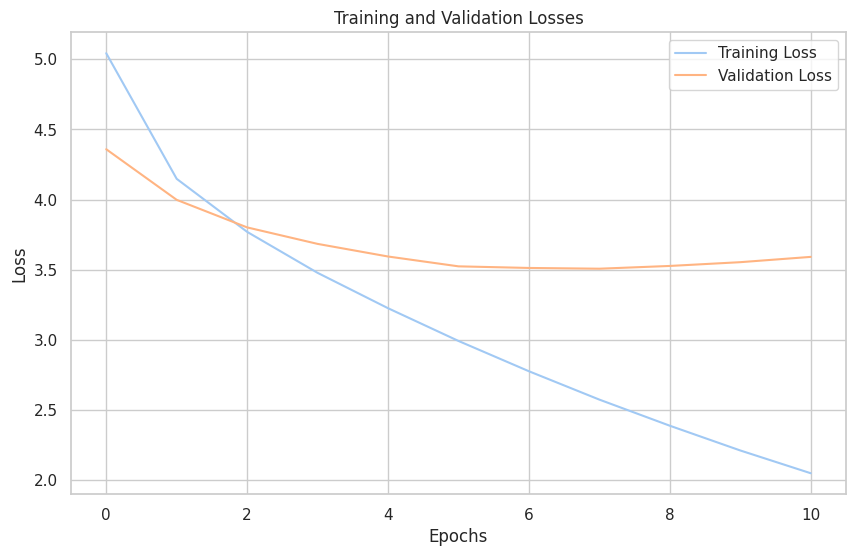

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Clearing GPU Cache**

In [21]:
torch.cuda.empty_cache()
del encoder_lite
del decoder_lite
del lite_train_dataloader
del lite_val_dataloader

#### Custom-Final

In [22]:
final_train_dataloader = get_dataloader(train_pairs, batch_size)
final_val_dataloader = get_dataloader(val_pairs, batch_size)

In [23]:
encoder_final = EncoderRNN(input_size=vocab_size, hidden_size=hidden_size, num_layers=3, embedding_matrix=embedding_matrix, bidirectional=True, freeze=freeze).to(device)
decoder_final = AttnDecoderRNN(hidden_size=hidden_size, output_size=vocab_size, num_layers=3, embedding_matrix=embedding_matrix, freeze=freeze).to(device)

In [24]:
total_params_encoder = count_trainable_parameters(encoder_final)
total_params_decoder = count_trainable_parameters(decoder_final)
total_params_attention = count_trainable_parameters(decoder_final.attention)

total_trainable_params = total_params_encoder + \
        total_params_decoder+total_params_attention
print(f'Total trainable parameters for Custom-Final: {total_trainable_params}')

Total trainable parameters for Custom-Final: 12027638


In [25]:
train_losses, val_losses = train(final_train_dataloader, final_val_dataloader, encoder_final, decoder_final, 30)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, Train Loss: 5.035814219254714, Validation Loss: 4.319617331027985
Epoch 2, Train Loss: 4.133549292270954, Validation Loss: 3.999552071094513
Epoch 3, Train Loss: 3.7710432663941993, Validation Loss: 3.815709725022316
Epoch 4, Train Loss: 3.4872624574563442, Validation Loss: 3.691672444343567
Epoch 5, Train Loss: 3.2357655769739395, Validation Loss: 3.617654725909233
Epoch 6, Train Loss: 3.0048994730680416, Validation Loss: 3.5963064581155777
Epoch 7, Train Loss: 2.7793595381272147, Validation Loss: 3.597187802195549
Epoch 8, Train Loss: 2.5601924627255173, Validation Loss: 3.6123267859220505
Epoch 9, Train Loss: 2.346029167297559, Validation Loss: 3.65430948138237
Epoch 10, Train Loss: 2.133701901558118, Validation Loss: 3.730892539024353
Early stopping triggered


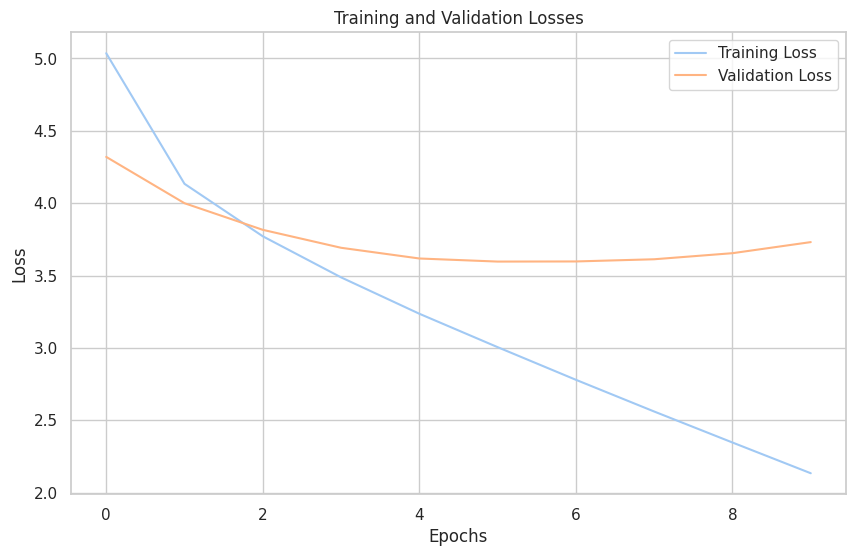

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Quantitative Analysis

In [27]:
# Custom-Lite save path
encoder_path_lite = '/content/drive/My Drive/COMP9444/models/Custom-Lite/encoder_best.pth'
decoder_path_lite = '/content/drive/My Drive/COMP9444/models/Custom-Lite/decoder_best.pth'

# Load the state dictionaries
encoder_state_dict_lite = torch.load(encoder_path_lite, map_location=torch.device(device))
decoder_state_dict_lite = torch.load(decoder_path_lite, map_location=torch.device(device))

# Reinitialising the Custom Lite Model
encoder_lite = EncoderRNN(input_size=vocab_size, hidden_size=hidden_size, num_layers=1, embedding_matrix=embedding_matrix, bidirectional=True, freeze=freeze).to(device)
decoder_lite = AttnDecoderRNN(hidden_size=hidden_size, output_size=vocab_size, num_layers=1, embedding_matrix=embedding_matrix, freeze=freeze).to(device)

# Apply the state dictionaries to the models
encoder_lite.load_state_dict(encoder_state_dict_lite)
decoder_lite.load_state_dict(decoder_state_dict_lite)

# Setting both the encoder and decoder to evaluation mode
encoder_lite.eval()
decoder_lite.eval()

# Generating Summaries
gen_summaries_lite, _ = evaluate(encoder_lite, decoder_lite, test_dialogues)

custom = {}

# Logging Metrics
custom['lite'] = generate_metrics(references, gen_summaries_lite)

  0%|          | 0/500 [00:00<?, ?it/s]

In [28]:
# Custom Final save path
encoder_path_final = '/content/drive/My Drive/COMP9444/models/Custom-Final/encoder_best.pth'
decoder_path_final = '/content/drive/My Drive/COMP9444/models/Custom-Final/decoder_best.pth'

# Load the state dictionaries
encoder_state_dict_final = torch.load(encoder_path_final, map_location=torch.device(device))
decoder_state_dict_final = torch.load(decoder_path_final, map_location=torch.device(device))

# Apply the state dictionaries to the models
encoder_final.load_state_dict(encoder_state_dict_final)
decoder_final.load_state_dict(decoder_state_dict_final)

# Setting both the encoder and decoder to evaluation mode
encoder_final.eval()
decoder_final.eval()

# Generating Summaries
gen_summaries_final, _= evaluate(encoder_final, decoder_final, test_dialogues)

# Logging Metrics
custom['final'] = generate_metrics(references, gen_summaries_final)

  0%|          | 0/500 [00:00<?, ?it/s]

In [29]:
# Creating results dataframe
custom_results = pd.DataFrame(custom).T

custom_results.columns = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-LSum', 'BLEU']
custom_results.index = ['Lite', 'Final']

custom_results[['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']]

,ROUGE-1,ROUGE-2,ROUGE-L,BLEU
Lite,0.286622,0.071541,0.232514,0.009362
Final,0.267051,0.056848,0.215349,0.008244


#### Qualitative Analysis

##### Experiments on Test Set

In [30]:
# Printing Summary for a random test dialogue to evaluate how well the model generates a summary
random_idx = np.random.randint(low = 0, high = len(test_dialogues))

print('Original Dialogue: ')
print(test_dialogues[random_idx])
print('----------------------')
print('Original Summary')
print(references[random_idx])
print('----------------------')
print('Generated Summary from Custom Lite: ')
print(gen_summaries_lite[random_idx])
print('----------------------')
print('Generated Summary from Custom Final: ')
print(gen_summaries_final[random_idx])

Original Dialogue: 
#Person1#: our company is going to do some cutbacks soon.
#Person2#: really? Where did you hear that?
#Person1#: I met with the supervisor just this morning. I don't know, but I am a little worried. Who do you think will get sacked?
#Person2#: I'm not sure. . . well, first, it couldn't be George. He is such a kiss-ass. He'd wash the boss's dog if he asked.
#Person1#: no, it's not going to be George. I don't think it's Andy either. He is involved with the boss's sister in-law. And you know how whipped our boss is.
#Person2#: that's true. What about Lisa? I bet there's nobody who could do a worse job than her.
#Person1#: Lisa? No way. I've heard a rumor that she and the boss were having an affair. You know rumors can't come out from nowhere.
#Person2#: well, okay. Then there is still Michael. But he's pet after having the best sales record for three months in a row. It definitely won't be Michael.
#Person1#: no, that would be crazy. But then who will it be? Oh dear, i

**Experiment 1:**
```
Original Dialogue:
#Person1#: Excuse me, could you tell me how to get to the school clinic? I've lost my way.
#Person2#: Yes. Go straight ahead till you come to the traffic lights, turn left there and it's the first turning on the right.
#Person1#: Straight ahead to the traffic lights, left and then right.
#Person2#: That's it. It'll take you about five minutes.
#Person1#: Thank you very much.
----------------------
Original Summary
#Person1# is lost on the way to the school clinic. #Person2# shows #Person1# the correct direction.
----------------------
Generated Summary from Custom Lite:
#person2# tells #person1# the way to the school and then #person1# tells #person2# the way to the school and the way to the <eos>
----------------------
Generated Summary from Custom Final:
#person2# tells #person1# how to get a new bus to the hospital because the traffic is the driver and the driver was the driver and the driver was <eos>
```

**Experiment 2:**
```
Original Dialogue:
#Person1#: Look, here is a copy of the Washington Post. Do you know when it was founded?
#Person2#: I happened to have a book right here about the development of newspapers. Let me see. Oh, it was founded in December eighteen seventy-seven by Stilson Hutchens.
#Person1#: Which newspaper is elder, the New York Times or the Washington Post?
#Person2#: The New York Times. It was founded in September eighteen fifty-one by Henry Raymond and George Jones.
#Person1#: How about the Los Angeles Times?
#Person2#: It was first published in December eighteen eighty-one, under the direction of Nathan Cole Junior and Thomas Guardineer.
----------------------
Original Summary
#Person2# tells #Person1# the founders and founding times of the Washington Post, the New York Times, and the Los Angeles Times.
----------------------
Generated Summary from Custom Lite:
#person1# tells #person2# about the new york in the states. #person2# tells #person1# about the of the trip. <eos>
----------------------
Generated Summary from Custom Final:
#person1# tells #person2# about the difference between the different of the ancient the awards and awards and the of the awards and awards and the of the <eos>
```

**Experiment 3:**
```
Original Dialogue:
#Person1#: Excuse me, Alice, I've never used this place before. Can you tell me how to use the machines?
#Person2#: What do you mean? These are the washing machines. Those big things over there are the dryers.
#Person1#: I see. Do the machines have soap in them?
#Person2#: No, of course not. You have to put soap in. Did you bring your soap?
#Person1#: No, I don't have soap.
#Person2#: Well, you can buy some over there.
#Person1#: Thanks. OK, I have my soap.
#Person2#: My god, you really bought a lot. Why do you need so much?
#Person1#: I don't know. I want my clothes to be clean.
#Person2#: But you can't use so much. The machines won't be able to remove the soap completely. On the contrary, too many bubbles trapped dirt, allowing bacteria to build up.
#Person1#: Oh, I guess I didn't know. I have never washed close before.
#Person2#: What? Did you say you never wash clothes before?
#Person1#: Yes, never.
#Person2#: I can't believe it. How can that be?
#Person1#: My mother always did it.
#Person2#: Yes, my mother washed my clothes, too. But when I was 12, I started to wash clothes myself.
#Person1#: I know about this fact. American children are more independent. But in my country, the mother wants her kids to get very good grades at school, so she does everything for the kids.
#Person2#: Then how are you going to survive on the campus?
#Person1#: I don't know. It's hard, but I have to learn.
----------------------
Original Summary
Alice guides #Person1# to use the washing machine and the dryer. Alice began to wash her clothes at the age of 12, but #Person1# has never done that before.
----------------------
Generated Summary from Custom Lite:
alice tells #person1# she is not happy with her old music and she wants to invest in the same thing, but she does not have much money. <eos>
----------------------
Generated Summary from Custom Final:
#person1# asks jack some shopping for a shopping show. #person1# tells #person2# that #person1# is going to buy some money. <eos>
```

##### Experiments on Hidden Set

In [31]:
# Printing Summary for a random hidden dialogue to evaluate how well the model generates a summary
random_idx = np.random.randint(low = 0, high = len(hidden_dialogues))

print('Original Hidden Dialogue: ')
print(hidden_dialogues[random_idx])
print('----------------------')
print('Generated Summary from Custom Lite: ')
print(evaluate(encoder_lite, decoder_lite, [hidden_dialogues[random_idx]])[0][0])
print('----------------------')
print('Generated Summary from Custom Final: ')
print(evaluate(encoder_final, decoder_final, [hidden_dialogues[random_idx]])[0][0])

Original Hidden Dialogue: 
#Person1#: It's a quite nice restaurant, isn't it, Director Hu?
#Person2#: Sure. I often have my lunch here. The food is tasty and they offer a big variety.
#Person1#: Yes, the beefsteak is inviting. I'll have beefsteak.
#Person2#: I'll have some fish and vegetables.
#Person1#: Where shall we seat?
#Person2#: How about by the window?
#Person1#: OK. You go first.
#Person2#: Xiao Liu. Where do you have lunch during your work time?
#Person1#: In the dining room of Education Bureau. What about you?
#Person2#: I often have lunch at home. My house is near my working place.
----------------------
Generated Summary from Custom Lite: 
#person1# and #person2# are discussing the restaurant in the restaurant and the food is not good at the hotel and the lunch room. <eos>
----------------------
Generated Summary from Custom Final: 
#person1# and #person2# are talking about the location of the lunch and the location of the hotel and the location of the hotel. <eos>



**Experiment 1:**
```
Original Hidden Dialogue:
#Person1#: I guess that we won't be going rollerblading today with all this rain!
#Person2#: Yes, rollerblading in six inches of water would not be fun. What would you like to do instead?
#Person1#: I think that maybe we could check out the local mall, grab some lunch, and maybe see a movie.
#Person2#: Yes, that sounds like a relaxing way to check out the local culture and still stay dry.
#Person1#: What else could we do in bad weather?
#Person2#: You know, we could take a double-decker bus tour of famous haunted houses and buildings.
#Person1#: That would be fun, and the rain would only add to the atmosphere.
#Person2#: There is an old English pub next door. Maybe when we finish with the haunted house, we can duck in there for some brew.
#Person1#: What a great idea!
#Person2#: If we are lucky, maybe they'll have some great food at the pub for supper.
----------------------
Generated Summary from Custom Lite:
#person1# and #person2# are going to check out of the local restaurants. they decide to check out the local local restaurants. <eos>
----------------------
Generated Summary from Custom Final:
#person1# and #person2# are going to the library before they decide to go to the restaurant in the office and they decide to go to the restaurant in the restaurant to buy some <eos>
```

**Experiment 2:**
```
Original Hidden Dialogue:
#Person1#: Excuse me. Do you have any vacancies tonight?
#Person2#: I'm sorry. We're completely booked. Oh, wait. I see someone canceled earlier today. We have one single room left.
#Person1#: Great. I need to get some sleep.
#Person2#: It's 700 dollars plus tax. Is that all right?
#Person1#: Yes, that's fine.
#Person2#: Just write down your name and address on this form. Will you be paying by credit card?
#Person1#: Yes.
#Person2#: May I see your card for a moment, so I can write down the number?
#Person1#: Yes. Here you are. Oh, by the way, will you give me a wakeup call at 7:30 tomorrow morning?
#Person2#: Certainly. Let me write that down hmm, seven thirty, okay! Here's your room key. You're in 714.
----------------------
Generated Summary from Custom Lite:
#person1# wants to get some check - out of credit card. #person2# tells #person1# to check the books and check out at the cost of $ 30 and helps #person2# to check the <eos>
----------------------
Generated Summary from Custom Final:
#person1# wants a seat but #person2# says it is wrong with #person1#' s assistance. #person1# asks #person2# to check the card and check the card and check the card in the afternoon. <eos>
```

**Experiment 3:**
```
Original Hidden Dialogue:
#Person1#: I just arrived and need help getting transportation to my hotel.
#Person2#: There are shuttles, taxis, and buses that go all over the city.
#Person1#: Which one is the best form of transportation?
#Person2#: It depends on where you want to go. If you are going to a well-known hotel, they have their own shuttles that drop you right off at the door.
#Person1#: Where can I catch a cab?
#Person2#: All ground transportation leaves from the island as you walk out the arrivals gate.
#Person1#: Where can I rent a car?
#Person2#: The car rental agencies are against the wall as you exit.
#Person1#: Are there any subways in this town?
#Person2#: We have a subway system, but you need to take a shuttle to get to the station.
----------------------
Generated Summary from Custom Lite:
#person1# wants to get a car but #person2# says it is a convenient service to take the car to the hotel and #person1# recommends a to take the car to get to the station. <eos>
----------------------
Generated Summary from Custom Final:
#person1# wants to buy a taxi to #person2# tells #person1# the parking is convenient and the parking is convenient and the parking ticket. #person2# suggests #person1# buy a bus station. <eos>
```



**Clearing GPU Cache**

In [32]:
torch.cuda.empty_cache()
del encoder_lite
del decoder_lite
del encoder_final
del decoder_final
del encoder_state_dict_lite
del decoder_state_dict_lite
del encoder_state_dict_final
del decoder_state_dict_final
del final_train_dataloader
del final_val_dataloader

A qualitative examination of the Custom Model's performance in these studies indicates significant flaws, particularly in its capacity to provide contextually accurate and cohesive summaries. These shortcomings can be linked to the model's static embeddings and provide insight into the possible benefits of moving to a model with context-aware embeddings, such as T5.


**Static Embedding**

The static embeddings employed in the Custom Model (Word2Vec enhanced with GloVe) are incapable of capturing the dynamic and contextual nuances of dialogues. Static embeddings represent words in a set way that ignores their varied meanings in different situations. This shortcoming is visible in the provided summaries, as the model fails to grasp the contextual relationship between dialogue turns and the overarching subject.


**Advantages of Context-Aware Embeddings in T5**

Moving to a paradigm that uses context-aware embeddings, such as T5, could alleviate these shortcomings:

1. **Dynamic Contextual Understanding**: T5's embeddings are context-aware, which means they modify word representation based on surrounding content. This enables a more sophisticated comprehension of dialogues and their inherent intricacies.

2. **Improved Coherence and Relevance**: By precisely capturing the substance and intricacies of the discourse, context-aware embeddings can improve the coherence and relevance of generated summaries.

3. **Language Representation Flexibility**: T5's Transformer-based architecture provides a flexible approach to language representation that can handle a wide range of linguistic nuances and variations.

4. **Improved Summarization Performance**: T5 was trained on a variety of linguistic tasks, including summarization. Because of its pre-training, as well as its context-awareness, it is well-suited for creating accurate and coherent summaries.


The static nature of embeddings in the Custom Model limits the ability to generate contextually accurate summaries significantly. Moving to a model like T5, which uses dynamic, context-aware embeddings, could increase the model's capacity to interpret and summarise complex talks significantly. T5's significant capabilities, derived from its Transformer design and intensive training, give it a potential option for dialogue summarising jobs.

### FLAN-T5 (Fine-tuned Language Nett on T5)

FLAN-T5 is a significant step forwards in the field of Natural Language Processing (NLP), notably in the context of transformer-based models. FLAN-T5, which stands for "Fine-tuned Language Nett on T5," is a variant of the original T5 model, also known as Text-to-Text Transfer Transformer. T5 is a versatile model that handles every NLP work as a text-to-text problem and has demonstrated extraordinary effectiveness across a wide range of NLP applications.

#### Evolution from T5

By utilising a unified framework that translates all tasks into a text-to-text format, the T5 model substantially altered the approach to NLP tasks. This architecture, which includes both an encoder and a decoder, enables the model to adapt to different tasks without requiring task-specific architectural adjustments.


#### Emergence of FLAN-T5

FLAN-T5 enhances T5's capabilities through a process known as instruction tuning. In contrast to traditional fine-tuning, which often focuses on specific tasks or datasets, instruction tuning entails training the model on a diverse selection of tasks delivered in a natural language instruction format. This technique allows FLAN-T5 to understand and execute tasks based on simple text instructions, greatly increasing its flexibility and generalisation capabilities.


#### Instruction Tuning: A Key Differentiator

FLAN-T5 is more flexible to a wide range of tasks thanks to instruction tuning, which requires little task-specific fine-tuning. This is especially useful for difficult tasks requiring a nuanced comprehension of language and context, such as text summary, question answering, and translation.


#### Implementing FLAN-T5

The FLAN-T5 model can be fine-tuned on specific datasets like DialogSum for practical applications such as dialogue summarising. This approach adapts the model's broad language comprehension to the specific needs of the task at hand. The `google/flan-t5-small` checkpoint was chosen for tests because it strikes a compromise between model complexity and computational efficiency, making it suited for a wide range of NLP tasks, including but not limited to dialogue summarising.


The development of FLAN-T5 represents a big step forwards in NLP, providing a model that is not only adaptable across tasks but also capable of understanding and executing tasks based on natural language instructions. This makes it an invaluable tool in the field of NLP, especially for tasks that need deep language comprehension and adaptability.


#### Pretrained FLAN-T5

In [33]:
flan_ckpt = 'google/flan-t5-small'
flan_tokenizer = AutoTokenizer.from_pretrained(flan_ckpt)
flan_model = AutoModelForSeq2SeqLM.from_pretrained(flan_ckpt)
save_ckpt = '/content/drive/My Drive/COMP9444/models/FLAN_T5/'

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

**Generating Summaries and Evaluating Pretrained Model**

In [34]:
flan_metrics = dict()
flan_pretrained_summaries = generate_summaries(test_dialogues, flan_model, flan_tokenizer, device)
flan_metrics['Pre Trained'] = generate_metrics(references, flan_pretrained_summaries)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

#### Fine-Tuning FLAN-T5

##### Importance of Fine-Tuning

FLAN-T5 fine-tuning on the DialogSum dataset is critical for various reasons:

1. **Task-Specific Adaptation**: While FLAN-T5 is pre-trained on a variety of tasks, fine-tuning it on dialogue summarization guarantees that the model's parameters are optimised for this particular application.
   
2. **Leveraging Pre-Trained Knowledge**: During the fine-tuning phase, the model is able to adapt its rich pre-trained language knowledge to the specific subtleties and structures found in dialogue summarization.

3. **Improving Model Performance**: Fine-tuning the model on a relevant dataset improves its capacity to create accurate and contextually relevant summaries.


##### Hyperparameter Selection

The selection of hyperparameters in the training phase is critical:

1. **Learning Rate**: A learning rate of `3e-5` finds a balance between efficient learning and stability, avoiding problems like as overfitting and underfitting.
   
2. **Warmup Steps**: Setting warmup steps to 200 aids in gradually increasing the learning rate, which can result in improved training dynamics and model convergence.

3. **Optimizer Selection**: The adoption of `adafactor` as the optimizer is notable due to its efficiency in dealing with big models and datasets, as well as its applicability for transformers.

4. **Batch Size and Weight Decay**: A batch size of 4 and a weight decay of 0.01 indicate a focus on meticulous, regularised learning while balancing computational restrictions and the necessity for effective gradient updates.

5. **Evaluation Strategy**: With steps defined every 50 iterations, the evaluation strategy enables for frequent monitoring of the model's performance, guaranteeing timely adjustments may be made throughout training.


A strategic approach to improving the model's skill in dialogue summarization is to fine-tune FLAN-T5 on the DialogSum dataset using carefully chosen hyperparameters. This procedure adapts the model to the specific properties of the dataset, ensuring that the pre-trained knowledge is applied effectively to generate coherent and contextually relevant summaries. The careful selection of hyperparameters aligns the training process even further with the goal of achieving optimal performance in the dialogue summarising task.


**Prepare data using a collator**

In [35]:
diasum = load_dataset('knkarthick/dialogsum')
diasum_pt = diasum.map(get_feature, batched=True, fn_kwargs={'tokenizer': flan_tokenizer})
diasum_pt.set_format('torch', columns=['input_ids', 'labels', 'attention_mask'])
data_collator = DataCollatorForSeq2Seq(flan_tokenizer, model=flan_model)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

**Setting up hyperparameters**

In [36]:
batch_size = 4
training_args = TrainingArguments(
    output_dir = 'flan_finetuned',
    overwrite_output_dir = True,
    num_train_epochs=3,
    learning_rate=3e-5,
    warmup_steps = 200,
    optim = "adafactor",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay = 0.01,
    logging_steps = 0.1,
    evaluation_strategy = 'steps',
    eval_steps=50,
    save_steps=1e6,
    gradient_accumulation_steps=16,
)

flan_trainer = Trainer(model=flan_model, args=training_args, tokenizer=flan_tokenizer, data_collator=data_collator,
                  train_dataset = diasum_pt['train'], eval_dataset = diasum_pt['validation'])

**Retrain FLAN-T5**

In [37]:
flan_trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
50,No log,1.613851
100,2.280300,1.425146
150,1.674400,1.372202
200,1.556900,1.335118
250,1.490700,1.314878
300,1.476000,1.305519
350,1.476000,1.297232
400,1.474000,1.289111
450,1.441400,1.283370
500,1.431300,1.281989


TrainOutput(global_step=582, training_loss=1.5712681144373524, metrics={'train_runtime': 840.4365, 'train_samples_per_second': 44.477, 'train_steps_per_second': 0.692, 'total_flos': 4599635437117440.0, 'train_loss': 1.5712681144373524, 'epoch': 2.99})

**Saving the fine-tuned model**

In [38]:
flan_trainer.save_model(save_ckpt)

**Generating Summaries and Evaluating Fine-tuned FLAN-T5**

In [39]:
flan_tokenizer = AutoTokenizer.from_pretrained(flan_ckpt)
flan_model = AutoModelForSeq2SeqLM.from_pretrained(flan_ckpt)

flan_fine_tokenizer = AutoTokenizer.from_pretrained(save_ckpt)
flan_fine_model = AutoModelForSeq2SeqLM.from_pretrained(save_ckpt)

In [40]:
flan_finetuned_summaries = generate_summaries(test_dialogues, flan_fine_model, flan_fine_tokenizer, device)
flan_metrics['Fine Tuned'] = generate_metrics(references, flan_finetuned_summaries)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

#### Quantitaive Analysis

In [41]:
flan_metrics = pd.DataFrame(flan_metrics).T
flan_metrics.columns = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-LSum', 'BLEU']
flan_metrics[['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']]

,ROUGE-1,ROUGE-2,ROUGE-L,BLEU
Pre Trained,0.150278,0.031144,0.133904,0.007740
Fine Tuned,0.371027,0.134330,0.307613,0.093357


According to the quantitative assessment, fine-tuning FLAN-T5 on the DialogSum dataset leads in significant increases in its summarising skills. The improved ROUGE and BLEU scores after fine-tuning suggest that the model's outputs are more aligned with the reference summaries, demonstrating its improved ability to generate coherent, relevant, and accurate summaries. This emphasises the significance of fine-tuning pre-trained models for specific tasks in NLP applications to get optimal performance.

#### Qualitative Analysis

##### Experiments on Test Set

In [42]:
# Printing Summary for a random test dialogue to evaluate how well the model generates a summary
random_idx = np.random.randint(low = 0, high = len(test_dialogues))

print('Original Dialogue: ')
print(test_dialogues[random_idx])
print('----------------------')
print('Original Summary')
print(references[random_idx])
print('----------------------')
print('Generated Summary from FLAN-T5 Pretrained: ')
print(flan_pretrained_summaries[random_idx])
print('----------------------')
print('Generated Summary from FLAN-T5 Finetuned: ')
print(flan_finetuned_summaries[random_idx])

Original Dialogue: 
#Person1#: John? It's Susan Miller.
#Person2#: Hi, Susan. What's up?
#Person1#: Do you know where that memo about office procedures is? I want to give my secretary a copy.
#Person2#: I'm sorry. I have no idea. I haven't seen that for ages.
#Person1#: Alright. Thank you anyway.
----------------------
Original Summary
Susan wants to find the memo. John has no idea where it is.
----------------------
Generated Summary from FLAN-T5 Pretrained: 
#Person1#: Thanks for the help. I'm sorry for the delay.
----------------------
Generated Summary from FLAN-T5 Finetuned: 
Susan Miller wants to give her secretary a copy of office procedures.


Experiment 1

```
Original Dialogue:
#Person1#: Is your city a historical place?
#Person2#: Not rally. 200 years ago, it was just a small insignificant village.
#Person1#: How did it grow into such a large place?
#Person2#: Large deposits of coal were found nearly and so many industries located themselves here. The village quickly grew into a key industrial centre.
#Person1#: As the city grew, it must have absorbed many village nearby.
#Person2#: Yes, it did. The names of those village survive as the names of parts of the city.
#Person1#: I see. Are there any building more than 200 years old in your city?
#Person2#: Oh, yes. Several of the buildings from the villages still survive. Many of them were inns for travelers and today survive as pubs. There was a castle near one village, so our city has a castle too.
#Person1#: Really? So your city does have some old history after all.
----------------------
Original Summary
#Person2#'s city was just a small insignificant village 200 years ago. It then grew into a key industrial centre for large deposits of coal and has absorbed many villages nearby.
----------------------
Generated Summary from FLAN-T5 Pretrained:
#Person1#: I think it is a historical place.
----------------------
Generated Summary from FLAN-T5 Finetuned:
#Person1# and #Person2# talk about the history of their city.
```
Experiment 2
```
Original Dialogue:
#Person1#: James, why are you watching TV? Your train leaves at 4:30. There are just 2 hours left. Have you finished packing?
#Person2#: I've almost finished packing. Now I'm waiting for the jacket I lent to David last week.
#Person1#: Which jacket, the gray one or the blue one?
#Person2#: Neither, the black one. It's my favorite. I want to wear it to the country because I want to take pictures there.
#Person1#: Then have you packed your camera in your bag?
#Person2#: No, few young people use cameras to take pictures now. A cellphone is good enough for taking pictures.
#Person1#: Well, I prefer to use a Camera, but it's up to you. Then have you put the cookies in your bag?
#Person2#: No, it's too heavy for me. I want to travel light.
#Person1#: I made them especially for your grandparents. They love my cookies very much. I'm sure they'll be disappointed if you don't take them with you. I've told them you take the cookies to them.
#Person2#: All right, I'll take them.
#Person1#: Good. So when will David get here?
#Person2#: He left home about 20 minutes ago. It takes him just 30 minutes to get here on foot. I guess, he'll be here in just about 10 minutes.
----------------------
Original Summary
#Person1# checks James' packing situation and asks him about his jacket and camera. #Person1# asks James to pack cookies and to give them to his grandparents.
----------------------
Generated Summary from FLAN-T5 Pretrained:
David will be here in about 10 minutes.
----------------------
Generated Summary from FLAN-T5 Finetuned:
James tells #Person1# he's waiting for the jacket he lent to David last
```

Experiment 3
```
Original Dialogue:
#Person1#: Stand back from the door, please. Let the passengers off. You can't get on until the other passengers get off.
#Person2#: How much is the fare, please?
#Person1#: One dollar. Drop it in the box. Move to the rear of the bus. There are plenty of seats in the rear.
#Person2#: Wait. I want to ask you if this bus goes down Fifth Avenue as far as Greenwich Village.
#Person1#: That's right. Move along, please. There are more people waiting to get on. Move to the rear.
#Person2#: I thought this bus Went down Park Avenue.
#Person1#: No, that's the number l that goes down Park Avenue. This is the number 2.
#Person2#: But I thought this was the right bus to go to Washington Square Park.
#Person1#: It is. Get in. please. You're holding everyone up. You can't miss Washington Square Park.
#Person2#: Would you tell me when we get there?
#Person1#: It would be better if you watched out for yourself. I might forget.
----------------------
Original Summary
#Person2# is holding everyone up, because #Person2# is standing back from the door and asking #Person1# whether this is the right bus to take.
----------------------
Generated Summary from FLAN-T5 Pretrained:
#Person2#: I'm sorry, but I'm not sure if
----------------------
Generated Summary from FLAN-T5 Finetuned:
#Person1# tells #Person2# the bus goes down Fifth Avenue as far
```




##### Experiments on Hidden Set

In [43]:
# Printing Summary for a random hidden dialogue to evaluate how well the model generates a summary
random_idx = np.random.randint(low = 0, high = len(hidden_dialogues))

print('Original Hidden Dialogue: ')
print(hidden_dialogues[random_idx])
print('----------------------')
print('Generated Summary from FLAN-T5 Pretrained: ')
print(generate_summaries([hidden_dialogues[random_idx]], flan_model, flan_tokenizer, device, progress= False)[0])
print('----------------------')
print('Generated Summary from FLAN-T5 Finetuned: ')
print(generate_summaries([hidden_dialogues[random_idx]], flan_fine_model, flan_fine_tokenizer, device, progress=False)[0])

Original Hidden Dialogue: 
#Person1#: I'm sorry for your loss. But there's nothing we can do for you.
#Person2#: Are you kidding? I pay my premium regularly. There is a fire, and I lost everything.
#Person1#: Listen, Mr. Ma. In the proposal form you were asked whether any inflammable materials were stored on the premises. You said 'no'. But we found that a ground floor storeroom was used to store dreams of petrol.
#Person2#: And you think I burned my own business premises with these drums of petrol?
#Person1#: I don't mean that. But the most good faith is one of the principles of insurance. What could we insure if everybody lied to us?
#Person2#: You are exaggerating the very fact. It's unfair. I cannot accept that.
#Person1#: Who is exaggerating?
#Person2#: I will sue you.
----------------------
Generated Summary from FLAN-T5 Pretrained: 
You are exaggerating. I will sue you. I will sue you.
----------------------
Generated Summary from FLAN-T5 Finetuned: 
Mr. Ma tells Mr. Ma that he 

Experiment 1
```
Original Hidden Dialogue:
#Person1#: I guess that we won't be going rollerblading today with all this rain!
#Person2#: Yes, rollerblading in six inches of water would not be fun. What would you like to do instead?
#Person1#: I think that maybe we could check out the local mall, grab some lunch, and maybe see a movie.
#Person2#: Yes, that sounds like a relaxing way to check out the local culture and still stay dry.
#Person1#: What else could we do in bad weather?
#Person2#: You know, we could take a double-decker bus tour of famous haunted houses and buildings.
#Person1#: That would be fun, and the rain would only add to the atmosphere.
#Person2#: There is an old English pub next door. Maybe when we finish with the haunted house, we can duck in there for some brew.
#Person1#: What a great idea!
#Person2#: If we are lucky, maybe they'll have some great food at the pub for supper.
----------------------
Generated Summary from FLAN-T5 Pretrained:
#Person1#: I think that we could go to the pub for supper
----------------------
Generated Summary from FLAN-T5 Finetuned:
#Person1# and #Person2# are going rollerblading in six inches
```

Experiment 2
```
Original Hidden Dialogue:
#Person1#: Excuse me. Do you have any vacancies tonight?
#Person2#: I'm sorry. We're completely booked. Oh, wait. I see someone canceled earlier today. We have one single room left.
#Person1#: Great. I need to get some sleep.
#Person2#: It's 700 dollars plus tax. Is that all right?
#Person1#: Yes, that's fine.
#Person2#: Just write down your name and address on this form. Will you be paying by credit card?
#Person1#: Yes.
#Person2#: May I see your card for a moment, so I can write down the number?
#Person1#: Yes. Here you are. Oh, by the way, will you give me a wakeup call at 7:30 tomorrow morning?
#Person2#: Certainly. Let me write that down hmm, seven thirty, okay! Here's your room key. You're in 714.
----------------------
Generated Summary from FLAN-T5 Pretrained:
#Person1#: I'm sorry. I'm sorry. I'm
----------------------
Generated Summary from FLAN-T5 Finetuned:
#Person2# helps #Person1# book a single room for 700 dollars plus
```

Experiment 3
```
Original Hidden Dialogue:
#Person1#: Hi, professor, how's everything going today?
#Person2#: Fine, I'm ready for your second question. What's that?
#Person1#: My second question is still about money. In ordinary form, is there a blank space between the currency and the amount?
#Person2#: No, there is not. For example, we should write HK $4,785 instead of HK $4,786.
#Person1#: Oh, I see. Is there anything I should be aware of when writing money amount?
#Person2#: On some formal bill, the capital form should begin with 'say' and end with 'only', to highlight the amount. For instance, 'Say five thousand and eighty five pounds sixty pence only'.
#Person1#: That's interesting. Can you show me another example?
#Person2#: Sure. 'Say six thousand and seventy seven US dollars only'.
#Person1#: I get a better understanding of foreign currencies through your explanation. Thank you very much. Goodbye.
#Person2#: You are welcome. Come here if you have any questions. Bye bye!
----------------------
Generated Summary from FLAN-T5 Pretrained:
#Person1#: I'm sorry, but I'm sorry. I'
----------------------
Generated Summary from FLAN-T5 Finetuned:
#Person1# asks #Person2# some questions about money and the capital form
```

**Clearing GPU Cache**

In [44]:
torch.cuda.empty_cache()
del flan_tokenizer
del flan_model
del flan_fine_tokenizer
del flan_fine_model
del flan_trainer

#### Comparative Insights
1. **Contextual Understanding**: When compared to the Custom Model, FLAN-T5 has a superior comprehension of the general idea of dialogues. It still has difficulty capturing exact details and essential parts of conversations.


2. **Coherence and Relevance**: The Custom Model, especially the Lite version, has a tendency to repeat or stray, but the FLAN-T5 improves coherence after fine-tuning. However, both models occasionally overlook the main point or dwell on irrelevant details.


3. **Fine-Tuning Improvements**: Fine-tuning FLAN-T5 results in summaries that are more aligned with the themes of the dialogues, while they still lack completeness and detail.

##### Suggested Improvements with a Model like BART

Using a more advanced pre-trained model, such as BART, may increase summarization quality for a variety of reasons, including:

1. **Richer Pre-Training**: BART's pre-training consists of a diverse set of readings and assignments that may provide a more in-depth understanding of language and context.

2. **Better Long Sequence Management**: BART's design can handle longer sequences, which could help capture the complete context of discussions.

3. **Advanced Generation Capabilities**: Because of the auto-regressive nature of BART and its strong design, more coherent and contextually suitable summaries may be generated.


Finally, while FLAN-T5 shows promise in understanding dialogues, especially after fine-tuning, its performance could be improved further by models such as BART, which are known for their superior handling of language production problems.


### BART (Bidirectional Auto-Regressive Transformer)

#### Introduction to BART

The Bidirectional Auto-Regressive Transformer (BART) is a significant advancement in the landscape of transformer-based models, which are mostly employed in Natural Language Processing (NLP). BART, as a self-supervised auto-encoder, distinguishes itself from its predecessors by combining the advantages of pretraining and autoregressive decoding into a single design. Its expertise spans a wide range of NLP tasks, including Natural Language Generation (NLG) and comprehension tasks.

#### Comparative Analysis of BART with BERT and GPT

- **BERT (Bidirectional Encoder Representations from Transformers)**: BERT's architecture is fundamentally bidirectional, allowing it to grasp context despite being primarily an encoder-only model. However, its architecture concentrates on independently predicting masked tokens, which does not lend itself well to generative tasks like text summarization.

- **GPT (Generative Pre-trained Transformer)**: GPT's decoder-only structure, on the other hand, allows for unidirectional token prediction, making it appropriate for generative workloads. The lack of bidirectional encoders, on the other hand, limits its ability to learn bidirectional context, which is critical for thorough understanding in summarization.

- **BART Advantages Over BERT and GPT**: BART combines BERT's bidirectional context learning capabilities with GPT's autoregressive generating capability. By efficiently recording the interdependencies of words in both directions of a sequence, BART is able to interpret and rebuild text. This type of characteristic is useful in text summarization, because knowing the whole extent of the information is as important as producing coherent summaries.

#### BART's Architectural Design

- **Standard Transformer Architecture**: BART follows the conventional sequence-to-sequence Transformer paradigm while innovating within it. In both the encoder and decoder, it has a 6-layer structure for the base model and a 12-layer structure for the larger variant.

- **Parameterization**: BART has around 10% more parameters than a BERT model of comparable size. This higher parameter count helps it learn and reflect complex linguistic patterns better.

- **Decoder Enhancements**: Each decoder layer in BART also performs cross-attention over the encoder's last hidden layer. This cross-attention technique allows for more sophisticated integration of encoded input data into the generating process.

- **Activation Functions and Initialisation**: Unlike GPT, BART uses Gaussian Error Linear Units (GeLUs) and an initialisation technique that draws parameters from a normal distribution with a mean of 0 and a standard deviation of 0.02.

#### BART's Performance in Summarization Tasks

BART has outperformed benchmark summarization datasets such as CNN/DailyMail and XSum. These datasets, distinguished by their distinct qualities, provide a comprehensive platform for assessing summarization techniques. BART's success in these benchmarks can be due to its effective mix of bidirectional understanding and autoregressive text production, which has set new standards in text summarization.

**Note: Due to computational constraints, we only use the `BART-Base` version for our experiments**

#### Pretrained BART


##### Overview of Pretraining in BART
Pretraining is an essential stage in the creation of BART, a cutting-edge transformer-based model for tasks such as text summarization. This procedure is divided into two distinct stages, each of which contributes to the model's ability to read and generate text in a distinctive manner.

**Stage One: Text Corruption with Noising Functions**

- **Objective**: The initial stage of pretraining involves purposefully changing the original text using various noising functions. This technique is crucial to the learning mechanism of BART.
  
- **Noising Techniques**: The following noising functions are used:
    - **Token Masking**: Random tokens in the text are masked in the same way as BERT does.
    - **Token Deletion**: At random, certain tokens are eliminated from the text.
    - **Text Infilling**: Masked random text spans are fed into the model, which is then tasked with predicting these spans.
    - **Sentence Permutation**: The sentence order in the text is shuffled.

The purpose of these modifications is to provide a tainted version of the text that tests the model's ability to absorb and forecast context despite the manufactured anomalies.

**Stage Two: Sequence-to-Sequence Model Training**

- **Reconstruction Objective**: The next stage is to train a sequence-to-sequence (Seq2Seq) model to map the distorted text back to its original, undamaged form. In this stage, the model is trained to offer the most likely sequence of tokens that corresponds to the original text.

- **Learning Process**: During this step, the Seq2Seq model is taught to predict the original, intact text from the corrupted input. This reconstruction procedure is crucial because it tests the model's ability to understand the language's basic structure, semantics, and context.

- **Capturing Meaningful Text Representations**: The model is driven to develop a deep understanding of the nuances of the language by rebuilding the original text from its corrupted version.  This learning strategy not only improves the model's language comprehension ability but also its ability to generate coherent and contextually relevant text.

**Implications for Text Summarization**

- **Enhanced Language Understanding**: The pretraining procedure gives BART a comprehensive understanding of language structure and context, which is necessary for the summarising task. By learning to restore authentic material from its distorted equivalent, BART develops a high sense for contextual significance and narrative coherence.

- **Downstream Task Preparation**: This pretraining establishes a good foundation for BART to excel in downstream NLG tasks, particularly summarization. The model's ability to read and recreate text allows it to properly and contextually summarise content.


In [45]:
bart_ckpt = 'facebook/bart-base'
bart_tokenizer = AutoTokenizer.from_pretrained(bart_ckpt)
bart_model = AutoModelForSeq2SeqLM.from_pretrained(bart_ckpt)
save_ckpt = '/content/drive/My Drive/COMP9444/models/BART/'

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

**Generating Summaries and Evaluating Pretrained model**

In [46]:
bart_metrics = dict()
bart_pretrained_summaries = generate_summaries(test_dialogues, bart_model, bart_tokenizer, device)
bart_metrics['Pre Trained'] = generate_metrics(references, bart_pretrained_summaries)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

####Finetuned BART

##### Introduction

Pre-trained models, such as BART (Bidirectional Auto-Regressive Transformer), must be fine-tuned before they can be applied to specific Natural Language Processing (NLP) applications. While BART's pre-training entails gaining a general grasp of language, fine-tuning tailors this model to specific tasks including abstractive text summarization, question-answering, and sentiment analysis. Let us look at why it is necessary to fine-tune BART for specialised NLP applications.


##### Improved Model Performance

- **Targeted Learning**: Fine-tuning the model entails training it on a dataset representative of the goal task. This tailored learning process significantly improves the model's performance on that task by aligning the model's understanding and outputs with the task's unique expectations and criteria.

- **Handling Domain-Specific Language**: Domain-specific terminology and concepts are used in many NLP tasks. BART may be fine-tuned on domain-specific data to efficiently grasp and apply such specialised language, which is critical for tasks like medical text summarising or legal document analysis.

##### Efficient Use of Computational Resources

- **Transfer Learning Advantage**: Instead of building a model from start, fine-tuning makes use of a pre-trained language model, which requires significantly less processing power and time. This makes it a more efficient method, particularly when dealing with large and complex models like as BART.

- **Achieving a Balance Between Generalisation and Overfitting**: Fine-tuning achieves a compromise between utilising pre-training generalisation and fitting the model closely enough to the specific task to avoid overfitting. This equilibrium is critical for obtaining peak performance on the task at hand.



**Prepare data using a collator**

In [47]:
diasum = load_dataset('knkarthick/dialogsum')
diasum_pt = diasum.map(get_feature, batched=True, fn_kwargs={'tokenizer': bart_tokenizer})
diasum_pt.set_format('torch', columns=['input_ids', 'labels', 'attention_mask'])
data_collator = DataCollatorForSeq2Seq(bart_tokenizer, model=bart_model)

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

##### Hyperparameter Optimization

The selection and tweaking of hyperparameters is crucial in fine-tuning the BART (Bidirectional Auto-Regressive Transformer) model for the job of abstractive text summarization. This report explains why different hyperparameters, such as the optimizer, weight decay, epoch count, and learning rate, were chosen for the purpose of summarising text on the DialogSum dataset.


###### Optimizer: AdamW

We use `AdamW` just as we did for `Custom-Lite` and `Custom-Final` model.

###### Weight Decay

- **Improved Generalisation**: The modified weight decay in AdamW helps to improve the model's generalisation performance while fine-tuning. This greater generalisation is critical for better performance on unseen data because BART is tailored to specific downstream tasks.

###### Training Epochs

- **Epoch Optimisation**: Empirical data show that increasing the number of training epochs from one to three improves performance significantly. However, increasing training to four epochs produced no discernible effect, indicating a performance plateau. As a result, a three-epoch training length is found as ideal, balancing computational economy with model effectiveness.

###### Learning Rate

- **Balanced Selection**: The learning rate of `3e-5` is chosen to create a compromise between sluggish convergence and the danger of overshooting during optimisation. A slower pace may inhibit learning, but a quicker rate may cause the model to overlook complex information, considering the complexity of the model, making this learning rate a reasonable choice.

###### Training Configuration

- **Arguments for Batch Size and Training**: Given the computational limits and the model's complexity, the `batch size` is set to `four`. The `TrainingArguments` include a `200-step` warming duration, gradient buildup over `16 steps`, and a weight decay of `0.01`. Furthermore, the model is evaluated every `50 steps` using an approach based on these intervals.

**Setting up hyperparameters**

In [48]:
batch_size = 4
training_args = TrainingArguments(
    output_dir = 'bart_finetuned',
    overwrite_output_dir = True,
    num_train_epochs=3,
    learning_rate=3e-5,
    warmup_steps = 200,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay = 0.01,
    logging_steps = 0.1,
    evaluation_strategy = 'steps',
    eval_steps=50,
    save_steps=1e6,
    gradient_accumulation_steps=16,
)

bart_trainer = Trainer(model=bart_model, args=training_args, tokenizer=bart_tokenizer, data_collator=data_collator,
                  train_dataset = diasum_pt['train'], eval_dataset = diasum_pt['validation'])

**Retrain BART**

In [49]:
bart_trainer.train()

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
50,No log,1.541243
100,2.536400,1.376409
150,1.604300,1.316123
200,1.490600,1.268086
250,1.397000,1.240216
300,1.354500,1.218068
350,1.354500,1.201810
400,1.317100,1.196711
450,1.296400,1.185810
500,1.237200,1.179885


TrainOutput(global_step=582, training_loss=1.4725765805064197, metrics={'train_runtime': 699.1885, 'train_samples_per_second': 53.462, 'train_steps_per_second': 0.832, 'total_flos': 7109069800734720.0, 'train_loss': 1.4725765805064197, 'epoch': 2.99})

**Saving the best model**

In [50]:
bart_trainer.save_model(save_ckpt)

**Generating Summaries and Evaluating Fine-tuned model**

In [51]:
bart_fine_tokenizer = AutoTokenizer.from_pretrained(save_ckpt)
bart_fine_model = AutoModelForSeq2SeqLM.from_pretrained(save_ckpt)

In [52]:
bart_finetuned_summaries = generate_summaries(test_dialogues, bart_fine_model, bart_fine_tokenizer, device)
bart_metrics['Fine Tuned'] = generate_metrics(references, bart_finetuned_summaries)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

#### Quantitaive Analysis

In [53]:
bart_metrics = pd.DataFrame(bart_metrics).T
bart_metrics.columns = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-LSum', 'BLEU']
bart_metrics[['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']]

,ROUGE-1,ROUGE-2,ROUGE-L,BLEU
Pre Trained,0.247642,0.054821,0.198870,0.017676
Fine Tuned,0.421529,0.173327,0.348935,0.125790


The quantitative study clearly shows the impact of fine-tuning BART for the summarization task. The significant increase in all ROUGE and BLEU scores upon fine-tuning suggests a significant improvement in the model's capacity to provide coherent, relevant, and accurate summaries. This demonstrates the value of fine-tuning pre-trained models like BART for specific tasks like summarization, allowing them to match more closely with the task's subtle criteria and deliver higher quality outputs.


#### Qualitative Analysis

##### Experiments on Test Set

In [54]:
# Printing Summary for a random test dialogue to evaluate how well the model generates a summary
random_idx = np.random.randint(low = 0, high = len(test_dialogues))

print('Original Dialogue: ')
print(test_dialogues[random_idx])
print('----------------------')
print('Original Summary')
print(references[random_idx])
print('----------------------')
print('Generated Summary from BART Pretrained: ')
print(bart_pretrained_summaries[random_idx])
print('----------------------')
print('Generated Summary from BART Finetuned: ')
print(bart_finetuned_summaries[random_idx])

Original Dialogue: 
#Person1#: John? It's Susan Miller.
#Person2#: Hi, Susan. What's up?
#Person1#: Do you know where that memo about office procedures is? I want to give my secretary a copy.
#Person2#: I'm sorry. I have no idea. I haven't seen that for ages.
#Person1#: Alright. Thank you anyway.
----------------------
Original Summary
Susan wants to find the memo. John has no idea where it is.
----------------------
Generated Summary from BART Pretrained: 
#Person1#: John? It's Susan Miller. Hello?#Person2#: Hi, Susan. What's up?
----------------------
Generated Summary from BART Finetuned: 
Susan Miller calls John to ask for a copy of the memo about office procedures.


Experiment 1

```
Original Dialogue:
#Person1#: John? It's Susan Miller.
#Person2#: Hi, Susan. What's up?
#Person1#: Do you know where that memo about office procedures is? I want to give my secretary a copy.
#Person2#: I'm sorry. I have no idea. I haven't seen that for ages.
#Person1#: Alright. Thank you anyway.
----------------------
Original Summary
Susan wants to find the memo. John has no idea where it is.
----------------------
Generated Summary from BART Pretrained:
#Person1#: John? It's Susan Miller. Hello?#Person2
----------------------
Generated Summary from BART Finetuned:
Susan Miller calls John to ask for a copy of the memo about office procedures.
```

Experiment 2

```
Original Dialogue:
#Person1#: Hi, can I talk to Mary, please?
#Person2#: This is Mary. Who's that speaking?
#Person1#: Hi, Mary. This is Greg Sonders from Brown College.
#Person2#: How can I help you, Mr. Sonders?
#Person1#: Well, your papers mention your impressive grade point average. And your test scores meet our admission standards. But we'd like to know if you'd be interested in college sports.
#Person2#: Definitely! I wrote on my application that I played high school basketball. In fact, I hold my school's all time record for points scored in a game.
#Person1#: Great! Do you play any other sports?
#Person2#: I also play volleyball.
#Person1#: Great! Well, you've certainly made an impression on us. We'll let you know our decision soon.
#Person2#: Thanks!
#Person1#: Goodbye.
----------------------
Original Summary
Mr. Sonders interviews Mary for college admission. Mary makes an impression on them.
----------------------
Generated Summary from BART Pretrained:
#Person1#: Hi, can I talk to Mary, please?#Person
----------------------
Generated Summary from BART Finetuned:
Greg Sonders from Brown College calls Mary to ask about her college sports. Mary
```

Experiment 3


```
Original Dialogue:
#Person1#: Are you paid on a commission or salary basis now?
#Person2#: I'm paid on a salary.
#Person1#: What's your monthly salary?
#Person2#: At present I get 1, 800 yuan per month.
#Person1#: How much do you hope to get a month here?
#Person2#: That's not the problem I care about. You can decide on my capacity and experience.
#Person1#: If we decide to hire you, we'd pay you two thousand and five hundred yuan a month at the start. You can have Saturdays and Sundays off. Besides, you may have a paid month holiday every year. How do you think about it?
#Person2#: Thank you, Mr. Brown. I really appreciate your assistance.
----------------------
Original Summary
Mr. Brown is interviewing #Person2# and they are talking over #Person2#'s salary.
----------------------
Generated Summary from BART Pretrained:
#Person1#: Are you paid on a commission or salary basis now?#
----------------------
Generated Summary from BART Finetuned:
Mr. Brown tells #Person1# he's paid on a commission or salary basis
```



##### Experiments on Hidden Set

In [55]:
# Printing Summary for a random hidden dialogue to evaluate how well the model generates a summary
random_idx = np.random.randint(low = 0, high = len(hidden_dialogues))

print('Original Hidden Dialogue: ')
print(hidden_dialogues[random_idx])
print('----------------------')
print('Generated Summary from BART Pretrained: ')
print(generate_summaries([hidden_dialogues[random_idx]], bart_model, bart_tokenizer, device, progress= False)[0])
print('----------------------')
print('Generated Summary from BART Finetuned: ')
print(generate_summaries([hidden_dialogues[random_idx]], bart_fine_model, bart_fine_tokenizer, device, progress=False)[0])

Original Hidden Dialogue: 
#Person1#: I'm sorry for your loss. But there's nothing we can do for you.
#Person2#: Are you kidding? I pay my premium regularly. There is a fire, and I lost everything.
#Person1#: Listen, Mr. Ma. In the proposal form you were asked whether any inflammable materials were stored on the premises. You said 'no'. But we found that a ground floor storeroom was used to store dreams of petrol.
#Person2#: And you think I burned my own business premises with these drums of petrol?
#Person1#: I don't mean that. But the most good faith is one of the principles of insurance. What could we insure if everybody lied to us?
#Person2#: You are exaggerating the very fact. It's unfair. I cannot accept that.
#Person1#: Who is exaggerating?
#Person2#: I will sue you.
----------------------
Generated Summary from BART Pretrained: 
Mr. Ma tells #Person1# he lost everything because of a fire and he burned his business premises with drums of petrol. #
----------------------
Generate

Experiment 1


```
Original Hidden Dialogue:
#Person1#: Mr. Chen, I will make a brief introduction of the office work to you.
#Person2#: OK, Miss Liu.
#Person1#: Our office is under the direct leadership of the general manager. The main task is to handle routine business, such as arranging meetings, meeting visitors, seeing visitors off, assigning work, making plans, sorting out the data and collecting information. All these affairs are very important. I'm sure you'll adapt quickly to the work here.
#Person2#: I hope so.
#Person1#: Mr. Chen, do you have anything to say about your work?
#Person2#: No. By the way, Secretary Liu, would you please tell me what the specific work is for me?
#Person1#: Sorry, I can't tell you now. After you are familiar with all these jobs, we will discuss the problem.
#Person2#: That's OK.
#Person1#: Mr. Chen, If you have something to say about your work while working, please come out. The people here are very helpful.
#Person2#: All right. Thank you.
----------------------
Generated Summary from BART Pretrained:
#Person1#: Mr. Chen, I will make a brief introduction of the
----------------------
Generated Summary from BART Finetuned:
Miss Liu introduces the office work to Mr. Chen and asks him to tell her the
```

Experiment 2
```
Original Hidden Dialogue:
#Person1#: Good morning, is this the Renter's Hotline?
#Person2#: Yes, what can I help you with?
#Person1#: I have a question about discrimination in housing.
#Person2#: What type of discrimination?
#Person1#: I think that he doesn't want to rent to me because of my race.
#Person2#: What made you think that your race was a problem?
#Person1#: He seemed OK talking to me on the phone, but seemed to change his mind when he saw me in person.
#Person2#: What else made you feel he was discriminating against you?
#Person1#: Well, he had a 25 unit apartment building and everyone I saw there was his same race.
#Person2#: Racial discrimination is very hard to prove, but if you would like to come down, we can go over a checklist that can help you build a case.
----------------------
Generated Summary from BART Pretrained:
#Person1#: Good morning, is this the Renter's Hotline?
----------------------
Generated Summary from BART Finetuned:
#Person1# calls the Renter's Hotline to ask about discrimination in housing
```

Experiment 3
```
Original Hidden Dialogue:
#Person1#: Hey, I got this parking ticket. Can you help me figure a way out of it?
#Person2#: First of all, did you park somewhere too long or in the wrong spot?
#Person1#: I was there too long.
#Person2#: Was the area clearly labeled with the time limit and all?
#Person1#: Yeah, I saw it.
#Person2#: You will need to convince the judge that you couldn't see the signs.
#Person1#: Yeah, I understand.
#Person2#: Whatever you do, you need to be respectful and polite to the judge.
#Person1#: Yeah, you're right.
#Person2#: Just try to talk to him about how sorry you are about the mistake you made, and promise that it won't happen again.
#Person1#: OK, I will.
----------------------
Generated Summary from BART Pretrained:
#Person1#: Hey, I got this parking ticket. Can you help me
----------------------
Generated Summary from BART Finetuned:
#Person1# got a parking ticket for parking in the wrong spot. #Person
```




**Clearing GPU Cache**

In [56]:
torch.cuda.empty_cache()
del bart_model
del bart_tokenizer
del bart_fine_model
del bart_fine_tokenizer
del bart_trainer
del diasum

#### Comparative Insights

1. **Contextual Understanding**: BART, especially when fine-tuned, outperforms the custom model and FLAN-T5 in terms of understanding the context and intent of talks. This is demonstrated by its capacity to condense the major points of discussions into short summaries.

2. **Coherence and Completeness**: BART's summaries are often more coherent and relevant to the dialogues than those provided by the custom model and FLAN-T5. However, limitations in recording the entire content of the interactions remain.

3. **Handling intricacies**: Due to its strong pre-training and transformer design, which allows for a deeper comprehension of language and context, BART appears to be better suited to manage the intricacies and nuances of discussions.

**BART's Differentiating Factors**

1. **Architecture**: BART mixes bidirectional encoding with autoregressive decoding to process and generate language effectively. This architecture is especially useful for summarising tasks since it recognises context and provides coherent tales.

2. **Pre-Training on Diverse Corpus**: BART has been pre-trained on a large corpus of tasks ranging from text infilling to sentence permutation. BART now has a deep comprehension of language and context thanks to its rigors training.

3. **Effective Fine-Tuning**: BART's fine-tuning capacity enables it to adapt its pre-trained knowledge to specific tasks such as summarising, producing summaries that are more aligned with the essential content of the conversations.


BART emerges as a strong contender for abstractive summarization in these studies, surpassing the proprietary encoder-decoder and FLAN-T5 models. Its architecture, along with thorough pre-training, allows it to provide coherent and contextually relevant summaries. While not without flaws, BART's success in these studies implies that it is a more effective tool for abstractive summarization, capable of comprehending and concisely presenting the substance of complicated talks. More fine-tuning and model changes could fix its existing weaknesses and improve its summarization capabilities.

### Conclusion

The comparison of various embedding methodologies in transformer models, notably static embeddings like GloVe and context-aware embeddings like BART and T5, offers significant conclusions that answer the research's primary aims.

#### Static vs. Context-Aware Embeddings

The investigation of static and context-aware embeddings in the paper demonstrates a considerable difference in performance, particularly in the field of dialogue summarization. Static embeddings, while capable of representing general language, fall short of capturing the dynamic and context-specific nuances of dialogues. Context-aware embeddings, on the other hand, display higher capabilities in understanding and adjusting to the different linguistic contexts within dialogues. The more coherent and contextually relevant summaries generated by models like BART and T5, which use dynamic, context-aware embeddings, demonstrate this improved performance.


#### Understanding of Embedding Technologies

This study adds greatly to our understanding of embedding technologies in NLP. By contrasting static embeddings with context-aware equivalents, it emphasises the need of contextual sensitivity in language models, particularly for activities that require a thorough comprehension of linguistic nuances, such as summarization. The results indicate that, while static embeddings provide a solid basis, the incorporation of context-aware embeddings is critical for tasks requiring a high level of linguistic comprehension and adaptability.

#### Comparative Model Selection

The comparison of several model architectures emphasises the importance of careful consideration in model selection based on the specific requirements of the work at hand. While Seq2Seq models with static embeddings are less resource-intensive and easier to construct, they may not be adequate for sophisticated tasks such as dialogue summarization. Advanced models, on the other hand, such as BART and T5, while more resource-intensive, offer significant performance advantages due to their context-aware nature. This study provides as a guide for academics and practitioners, emphasising the trade-offs involved in model selection and emphasising the significance of matching model capabilities to task-specific objectives.


Finally, the study achieves its goals by proving the superiority of context-aware embeddings in handling complicated NLP tasks and offering a comparison framework for informed model selection. It lays the way for future research into embedding technology, calling for more dynamic, context-sensitive models in tasks requiring a nuanced grasp of language.
